# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 24.04.2025

Мягкий дедлайн: 13.05.2025 23:59 MSK

Жесткий дедлайн: 18.05.2025 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

/Users/polina/Desktop/homeworks/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [2]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [5]:
df['Class'].unique()

array([0, 1])

In [6]:
print(f"Доля положительных объектов в выборке: {df[df['Class']==1].shape[0]/df.shape[0]:4f}")

Доля положительных объектов в выборке: 0.001727


Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [7]:
df['Hour'] = (df['Time'] // 3600) % 24
df['Day'] = (df['Time'] // (3600 * 24)).astype(int)

num_days = df['Day'].nunique()
print(f"Данные покрывают {num_days} дня")

Данные покрывают 2 дня


Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

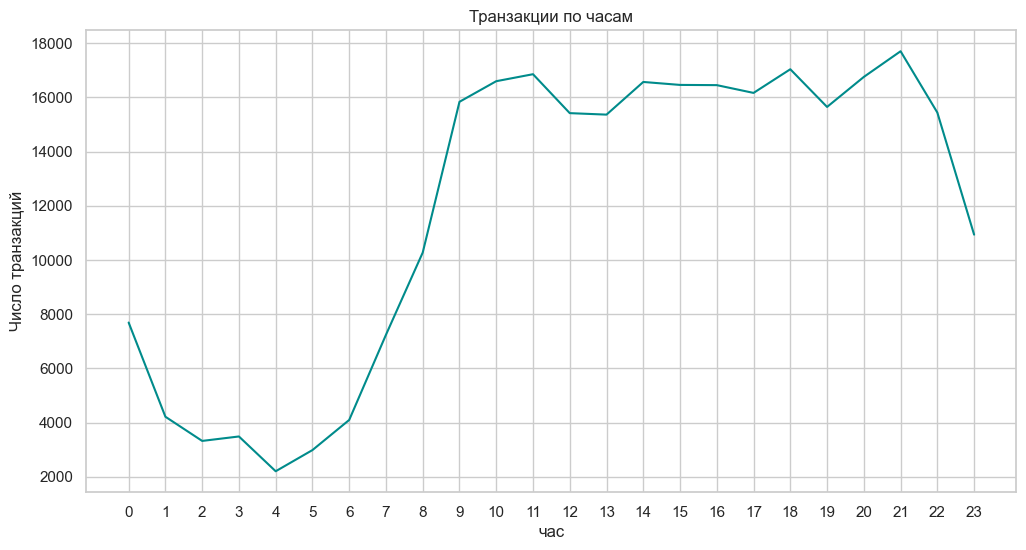

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.groupby('Hour').size(), color='darkcyan')
plt.xlabel('час')
plt.ylabel('Число транзакций')
plt.title('Транзакции по часам')
plt.xticks(range(24))
plt.show()

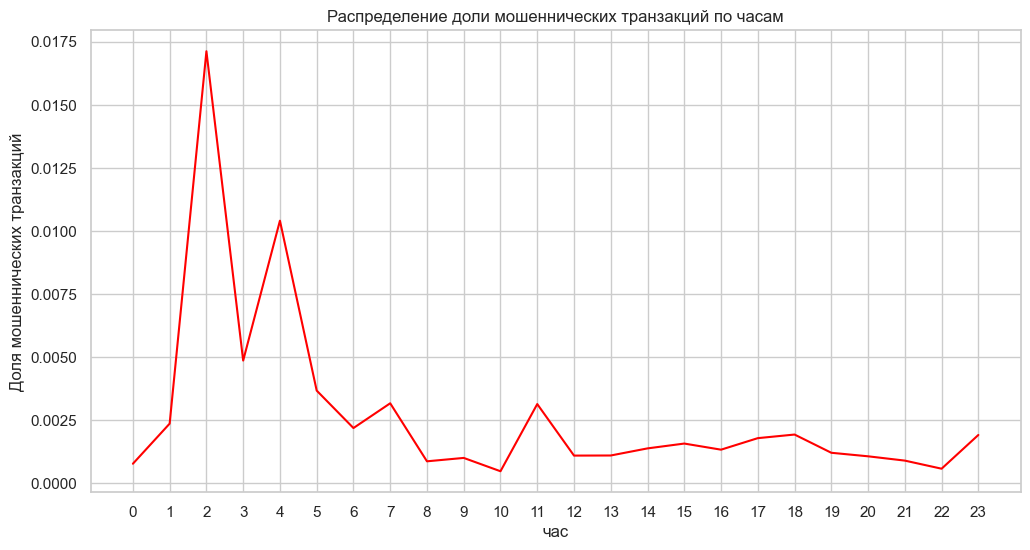

In [9]:
hourly_fraud = df.groupby('Hour')['Class'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_fraud, color='red')
plt.title('Распределение доли мошеннических транзакций по часам')
plt.xlabel('час')
plt.ylabel('Доля мошеннических транзакций')
plt.xticks(range(24))
plt.grid(True)
plt.show()

Полученные нами часы очень похожи на реальные часы в сутках, поскольку с 0 до 4 число тразакций падает, а затем растет до 9 и достигает примерно стабильного уровня с 9 до 22 - похоже на реальное отсуствие транзакций ночью и основную часть транзакций, проводимых в течение дня

Если говорить про мошеннические транзакции, их доля наиболее высока как раз в ночной период, когда транзакций в целом мало, а начиная примерно с 6 утра и до 22 их доля относительно низкая и примерно стабильная (в период высокой активности в целом)

В целом, абсолютное количество мошеннических транзакций всегда небольшое, но вот относительно общего числа (предполагаю, что) ночью (с 2 до 6) наибольший риск их возникновения

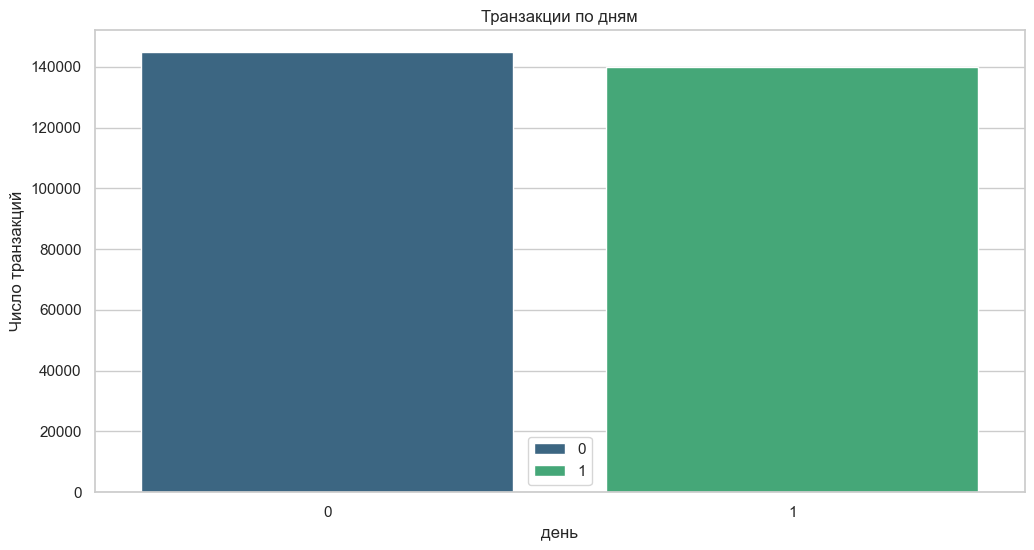

In [10]:
daily_transactions = df.groupby('Day').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=daily_transactions.index, y=daily_transactions.values, palette="viridis", hue=daily_transactions.index)
plt.xlabel('день')
plt.ylabel('Число транзакций')
plt.title('Транзакции по дням')
plt.legend()
plt.show()

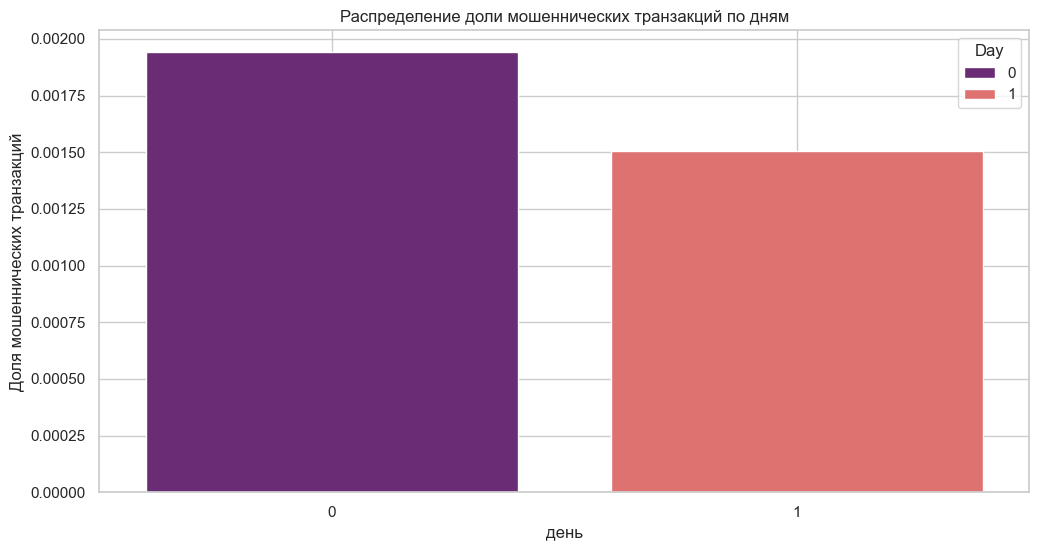

In [11]:
daily_fraud = df.groupby('Day')['Class'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=daily_fraud.index, y=daily_fraud.values, palette="magma", hue=daily_fraud.index)
plt.title('Распределение доли мошеннических транзакций по дням')
plt.xlabel('день')
plt.ylabel('Доля мошеннических транзакций')
plt.grid(True)
plt.show()

По дням общее число транзакций примерно очень близко друг к другу, а если говорить про долю мошеннических - она выше в первый день, чем во второй

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

<Axes: >

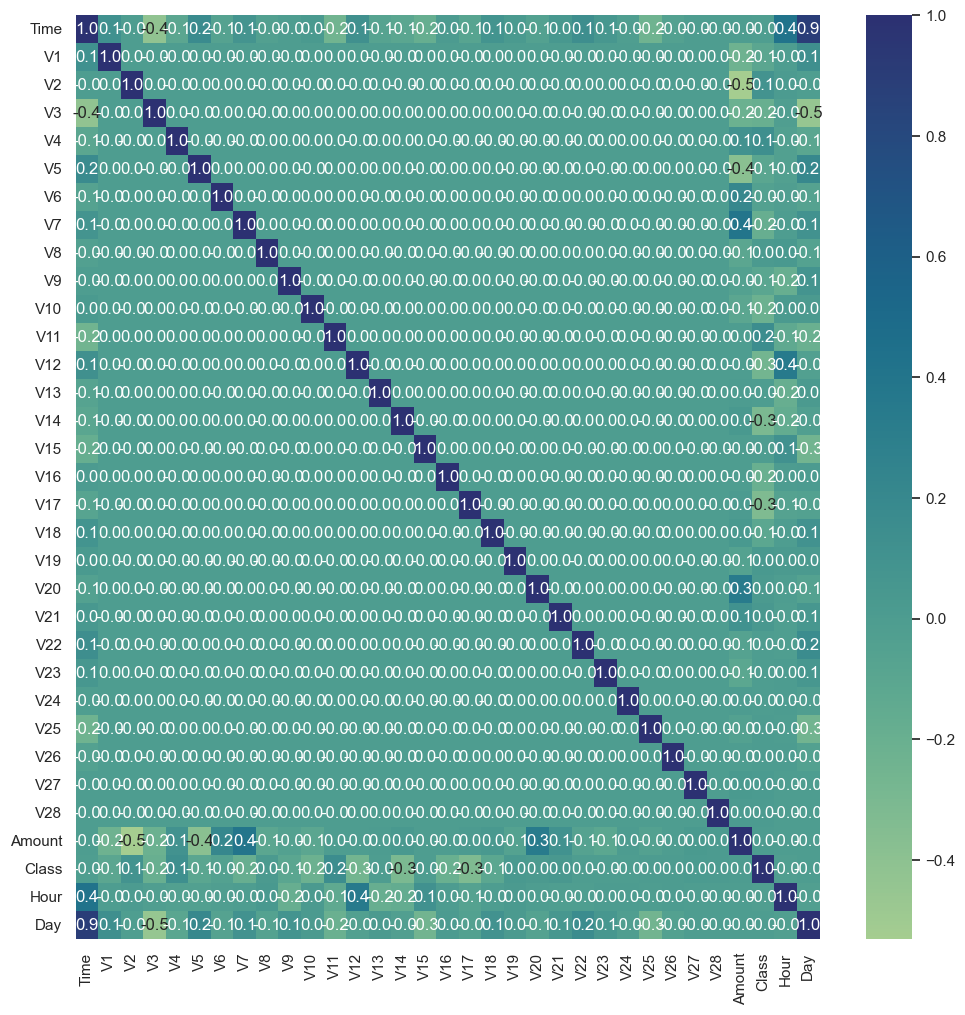

In [15]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="crest")

Поскольку ничего не видно, уберем совсем нулевые по корреляции признаки

In [16]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour', 'Day'],
      dtype='object')

<Axes: >

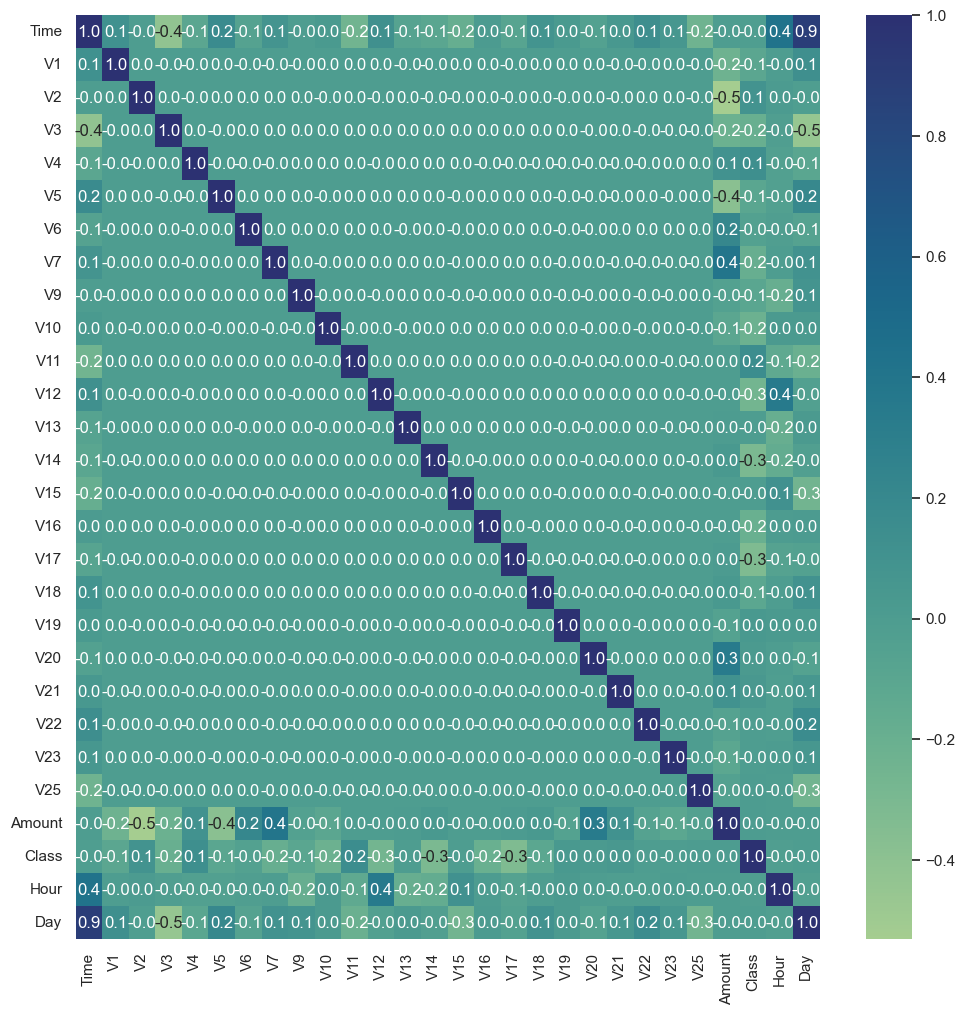

In [18]:
corr_matrix = df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V25', 'Amount',
       'Class', 'Hour', 'Day']].corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="crest")

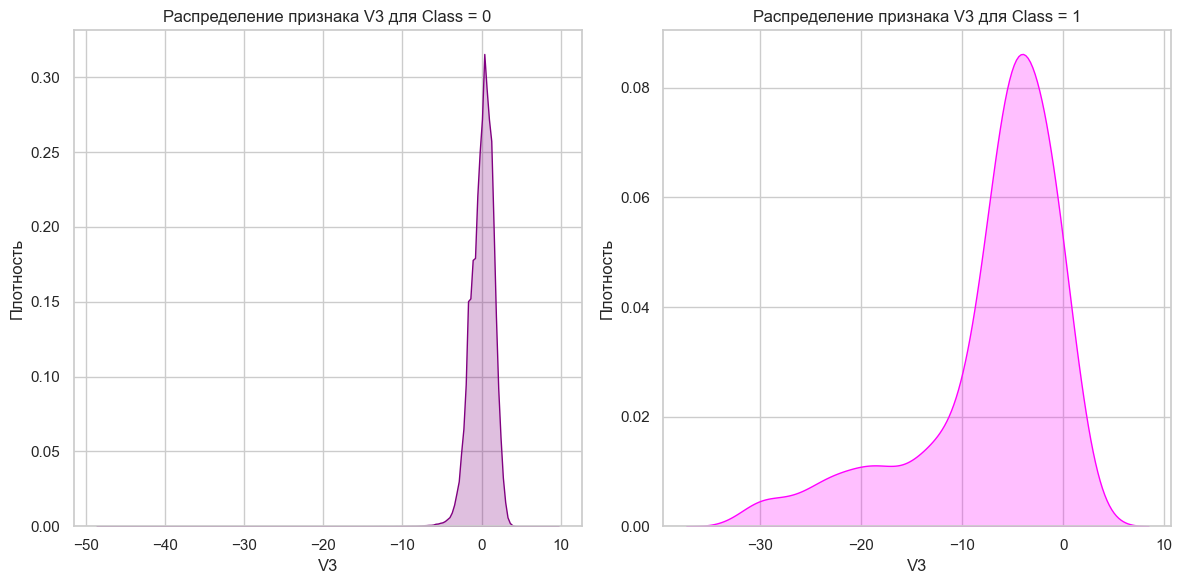

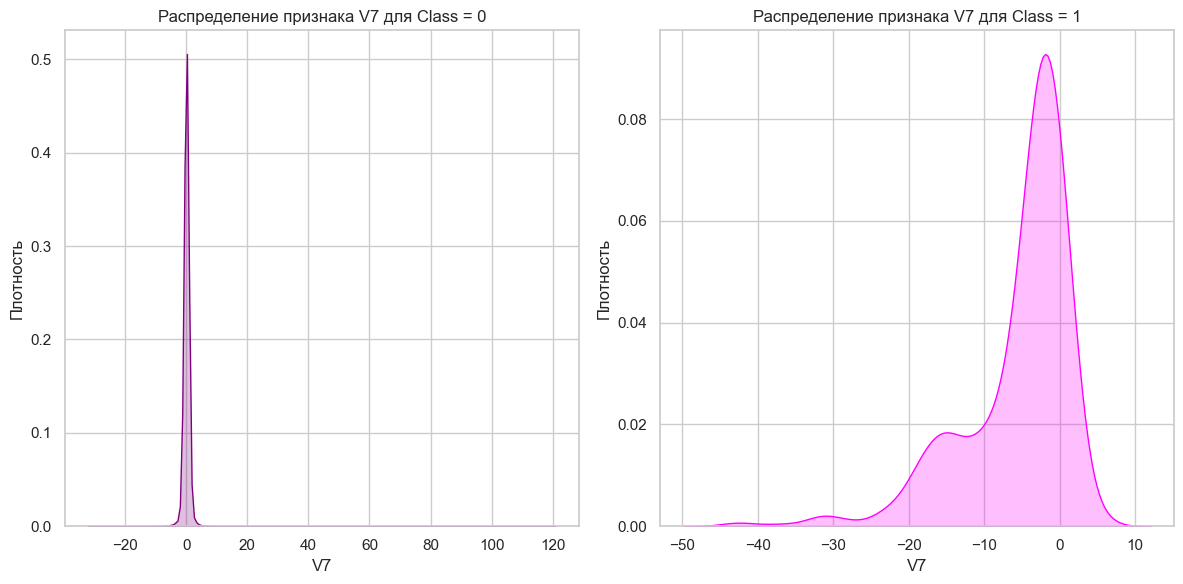

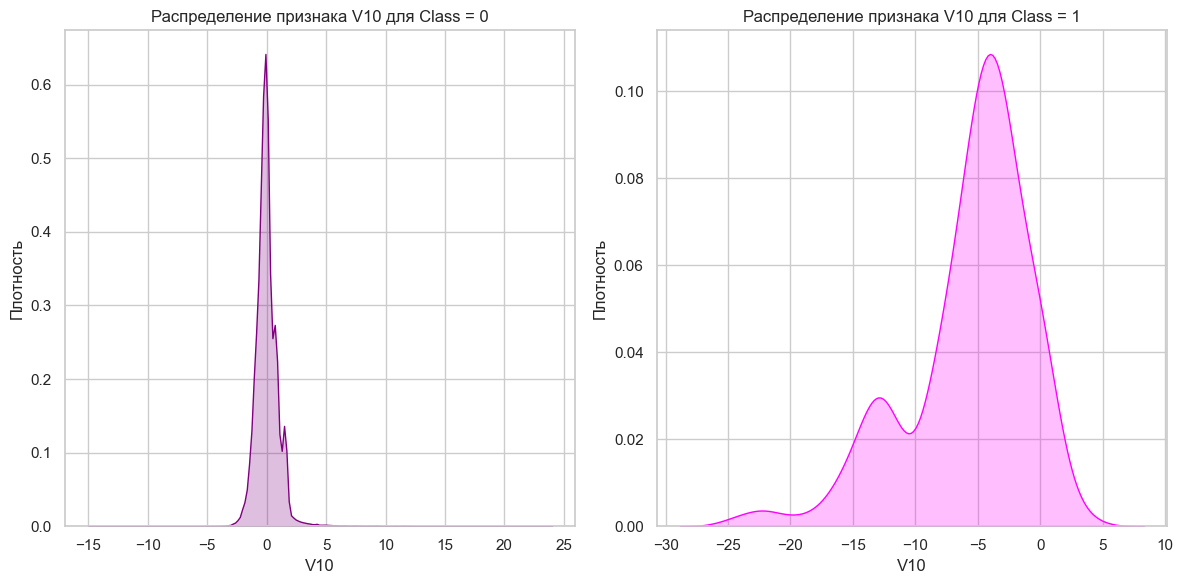

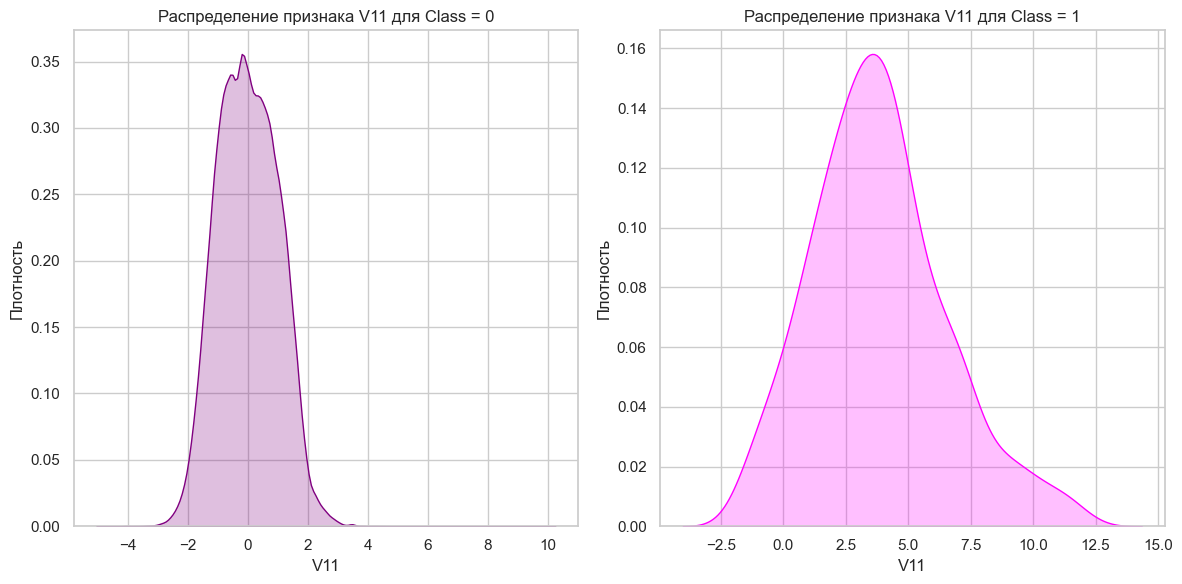

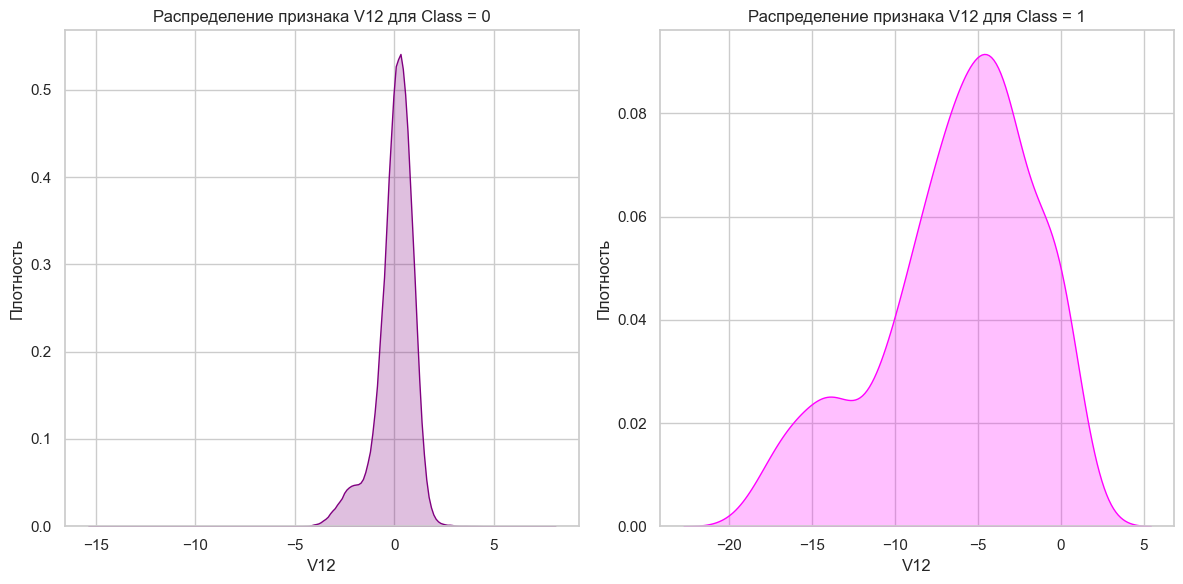

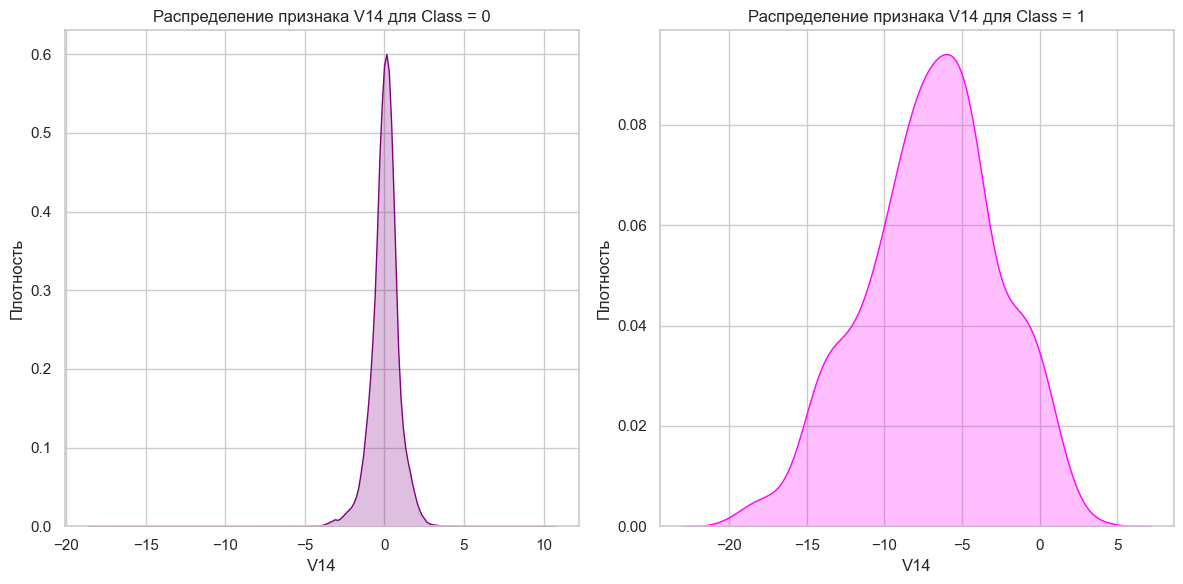

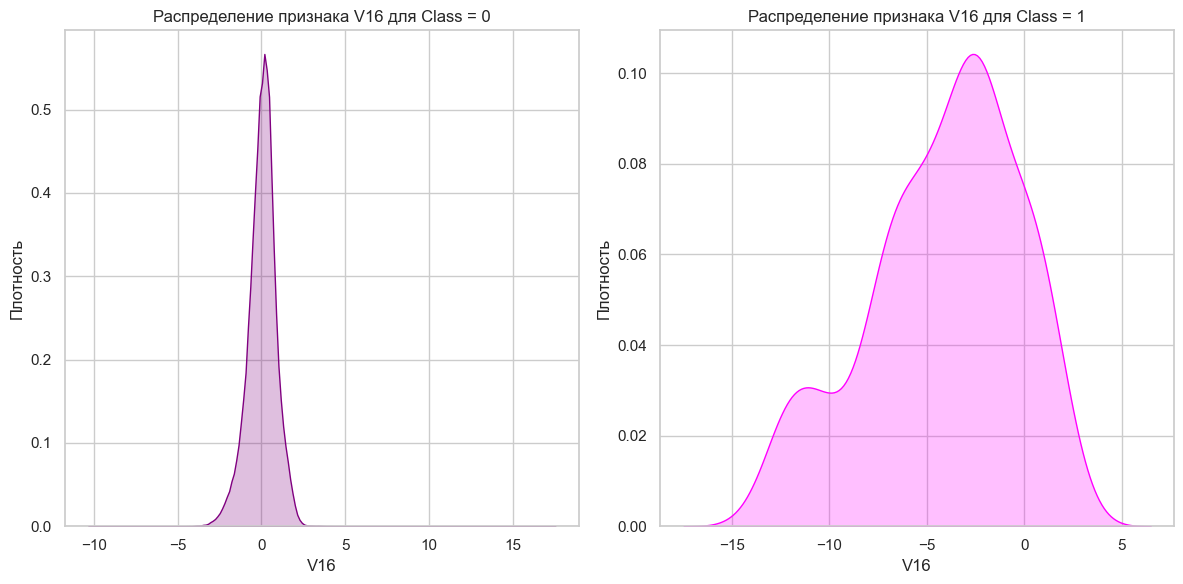

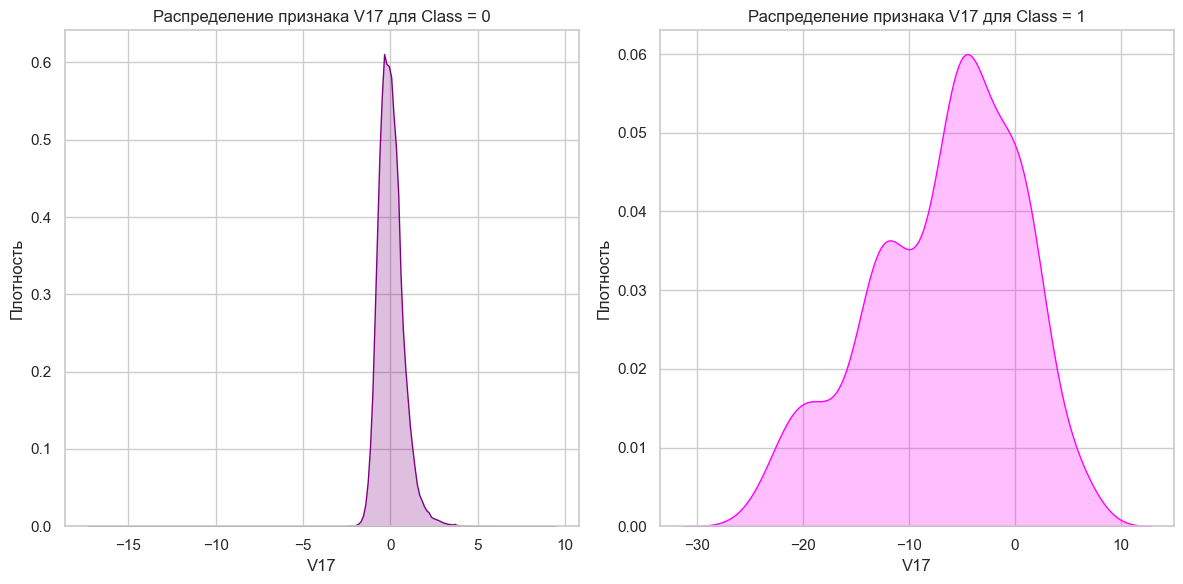

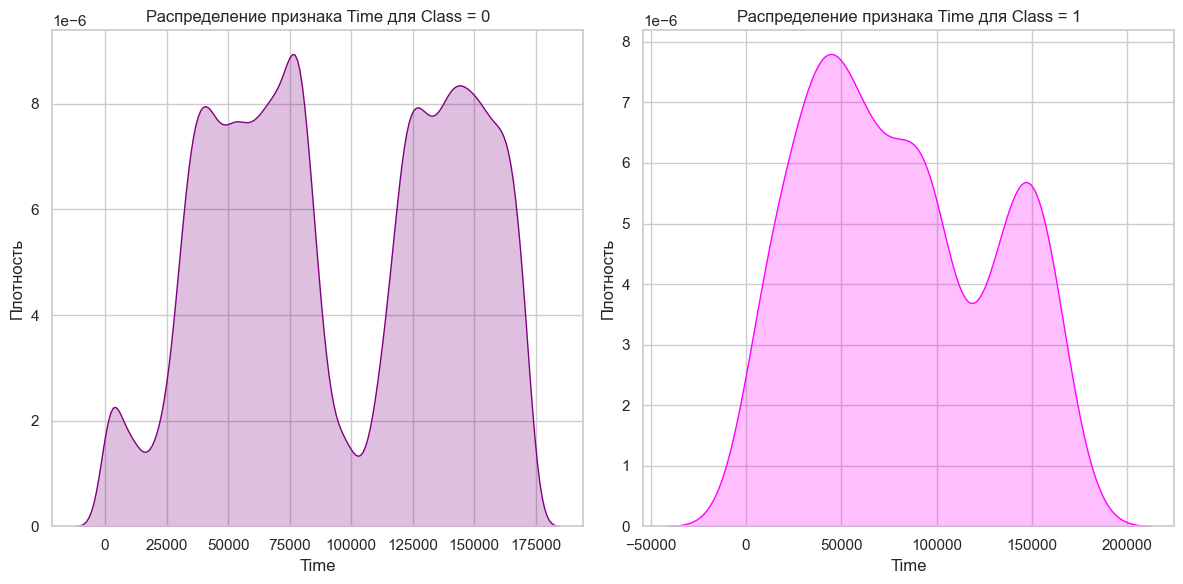

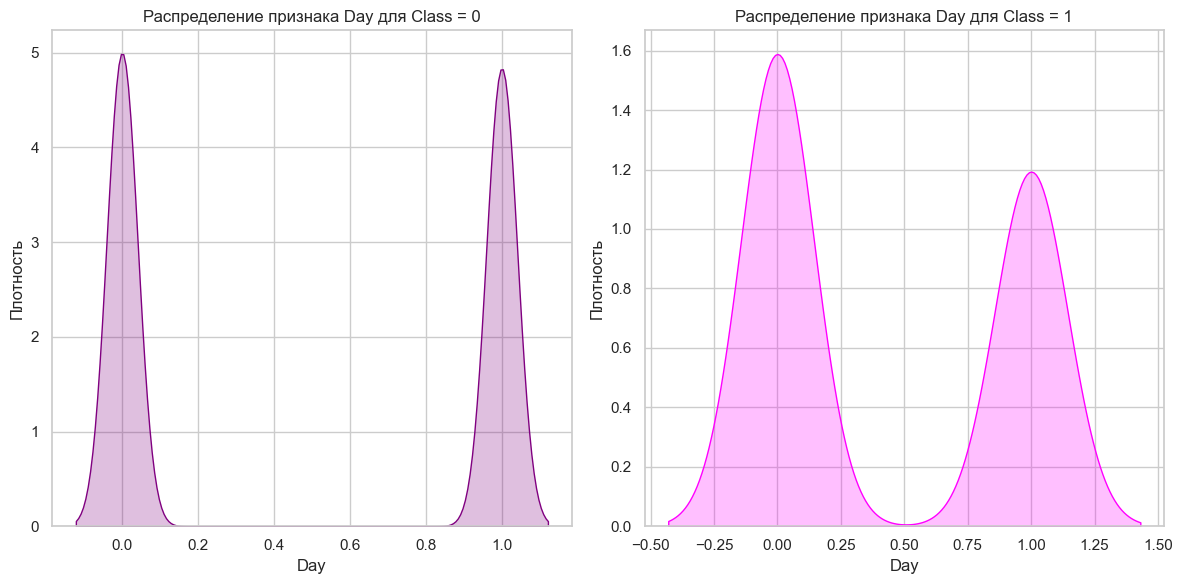

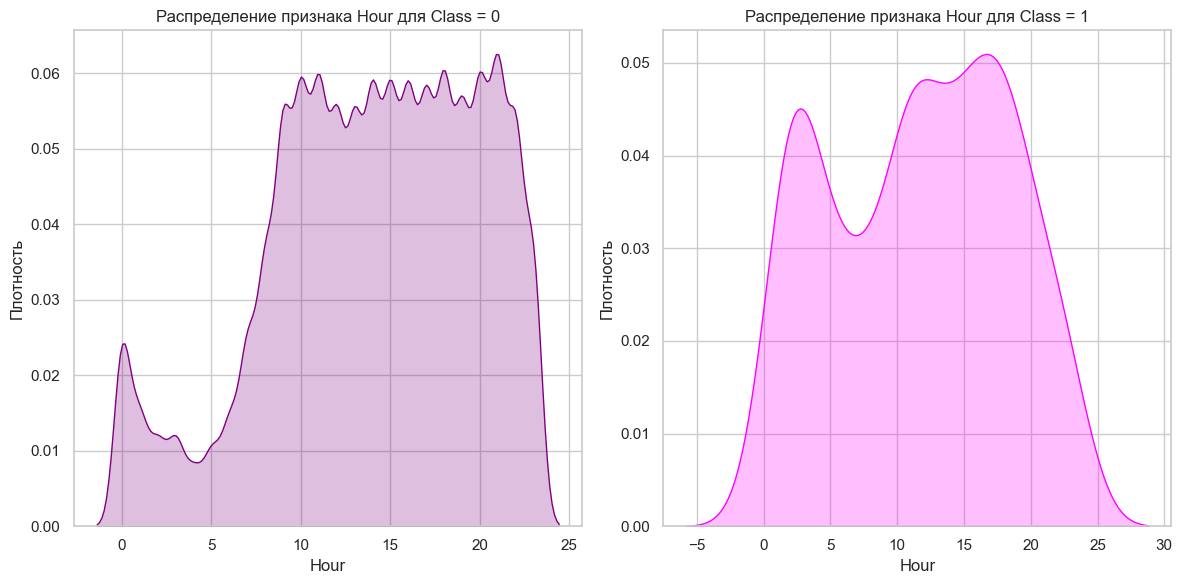

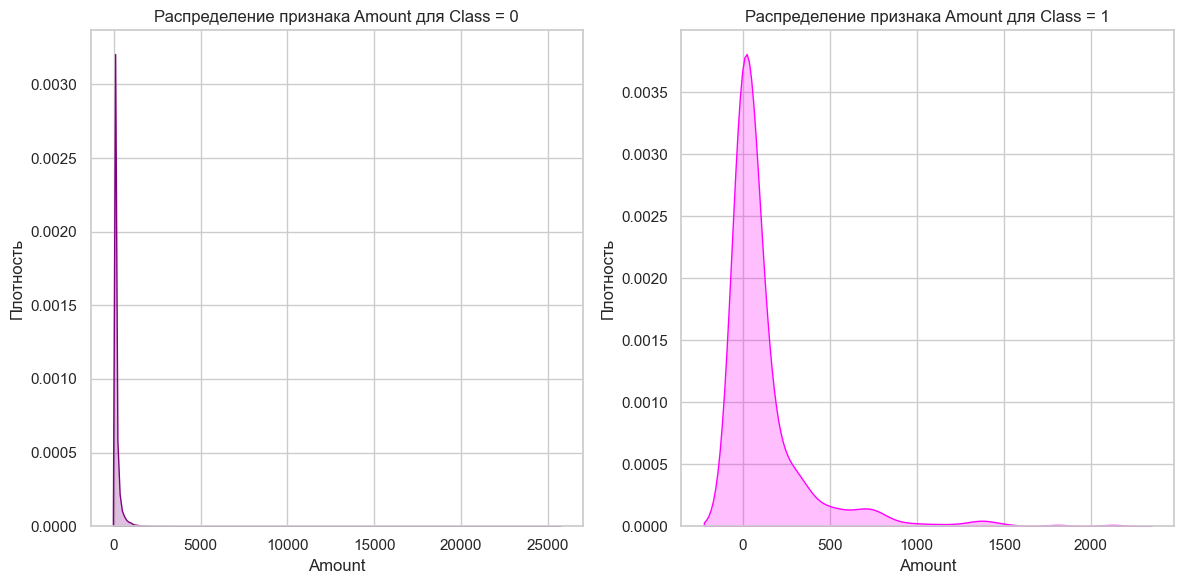

In [24]:
features = ['V3', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Time', 'Day', 'Hour', 'Amount']

for feat in features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.kdeplot(data=df[df['Class'] == 0], x=feat, fill=True, color='purple', ax=axes[0])
    axes[0].set_title(f'Распределение признака {feat} для Class = 0')
    axes[0].set_xlabel(feat)
    axes[0].set_ylabel('Плотность')
    axes[0].grid(True)
    
    sns.kdeplot(data=df[df['Class'] == 1], x=feat, fill=True, color='magenta', ax=axes[1])
    axes[1].set_title(f'Распределение признака {feat} для Class = 1')
    axes[1].set_xlabel(feat)
    axes[1].set_ylabel('Плотность')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [26]:
size = int(len(df) * 0.2)  
test_size = size // 2
val_size = size - test_size

train_df = df.iloc[:len(df) - size]
val_df = df.iloc[len(df) - size:len(df) - test_size]
test_df = df.iloc[len(df) - test_size:]

In [28]:
X_train = train_df.drop(columns = ['Class'])
y_train = train_df['Class']

X_val = val_df.drop(columns=['Class'])
y_val = val_df['Class']

X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

print(f"size of train: {len(train_df)} ({len(train_df)/len(df)})")
print(f"size of val: {len(val_df)} ({len(val_df)/len(df)})")
print(f"size of test: {len(test_df)} ({len(test_df)/len(df)})")

print(f"train: {y_train.value_counts()}")
print(f"val: {y_val.value_counts()}")
print(f"test: {y_test.value_counts()}")

size of train: 227846 (0.8000014044598623)
size of val: 28481 (0.10000105334489671)
size of test: 28480 (0.09999754219524098)
train: Class
0    227429
1       417
Name: count, dtype: int64
val: Class
0    28428
1       53
Name: count, dtype: int64
test: Class
0    28458
1       22
Name: count, dtype: int64


# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [30]:
from sklearn.metrics import average_precision_score

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [31]:
from sklearn.metrics import cohen_kappa_score

In [94]:
from sklearn.metrics import confusion_matrix

def cohen_kappa_manual(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = cm.sum()
    po = (cm[0, 0] + cm[1, 1]) / n
    pe = ((cm[0, 0] + cm[1, 0]) * (cm[0, 0] + cm[0, 1]) + (cm[0, 1] + cm[1, 1]) * (cm[1, 0] + cm[1, 1])) / (n * n)
    return (po - pe) / (1 - pe)

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [32]:
from sklearn.metrics import matthews_corrcoef

In [93]:
def matthews_corrcoef_manual(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    num = (tp * tn) - (fp * fn)
    den = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    if den == 0:
        return 0.0
    return num / den

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [364]:
y_pred_cb_test = np.zeros(len(y_test))
print(f"kappa: {cohen_kappa_score(y_test, y_pred_cb_test)}")
print(f"kappa manual: {cohen_kappa_manual(y_test, y_pred_cb_test)}")
print(f"mcc: {matthews_corrcoef(y_test, y_pred_cb_test)}")
print(f"mcc manual: {matthews_corrcoef_manual(y_test, y_pred_cb_test)}")
print(f"auc_pr: {average_precision_score(y_test, y_pred_cb_test)}")

kappa: 0.0
kappa manual: 0.0
mcc: 0.0
mcc manual: 0.0
auc_pr: 0.0007724719101123596


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [37]:
from catboost import CatBoostClassifier

In [96]:
model_cb_w = CatBoostClassifier(verbose=100, random_seed=42)
model_cb_w.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred_cb_test = model_cb_w.predict(X_test)
y_pred_proba_cb_test = model_cb_w.predict_proba(X_test)[:, 1] 

print(f"kappa: {cohen_kappa_score(y_test, y_pred_cb_test)}")
print(f"kappa manual: {cohen_kappa_manual(y_test, y_pred_cb_test)}")
print(f"mcc: {matthews_corrcoef(y_test, y_pred_cb_test)}")
print(f"mcc manual: {matthews_corrcoef_manual(y_test, y_pred_cb_test)}")
print(f"auc_pr: {average_precision_score(y_test, y_pred_proba_cb_test)}")

Learning rate set to 0.121129
0:	learn: 0.3193510	test: 0.3164616	best: 0.3164616 (0)	total: 34.3ms	remaining: 34.2s
100:	learn: 0.0014442	test: 0.0026623	best: 0.0026623 (100)	total: 2.01s	remaining: 17.9s
200:	learn: 0.0010080	test: 0.0027258	best: 0.0026447 (111)	total: 3.45s	remaining: 13.7s
300:	learn: 0.0007124	test: 0.0027400	best: 0.0026447 (111)	total: 4.83s	remaining: 11.2s
400:	learn: 0.0004998	test: 0.0027970	best: 0.0026447 (111)	total: 6.19s	remaining: 9.24s
500:	learn: 0.0003160	test: 0.0029740	best: 0.0026447 (111)	total: 7.56s	remaining: 7.53s
600:	learn: 0.0002203	test: 0.0032102	best: 0.0026447 (111)	total: 9.19s	remaining: 6.1s
700:	learn: 0.0001538	test: 0.0033477	best: 0.0026447 (111)	total: 10.6s	remaining: 4.53s
800:	learn: 0.0001192	test: 0.0034725	best: 0.0026447 (111)	total: 12s	remaining: 2.98s
900:	learn: 0.0000993	test: 0.0035607	best: 0.0026447 (111)	total: 13.3s	remaining: 1.46s
999:	learn: 0.0000887	test: 0.0035782	best: 0.0026447 (111)	total: 14.6s	rem

Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [51]:
model_cb_w = CatBoostClassifier(verbose=100, random_seed=42, auto_class_weights='Balanced')
model_cb_w.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred_cb_test = model_cb_w.predict(X_test)
y_pred_proba_cb_test = model_cb_w.predict_proba(X_test)[:, 1] 

print(f"kappa: {cohen_kappa_manual(y_test, y_pred_cb_test)}")
print(f"mcc: {matthews_corrcoef_manual(y_test, y_pred_cb_test)}")
print(f"auc_pr: {average_precision_score(y_test, y_pred_proba_cb_test)}")

Learning rate set to 0.121129
0:	learn: 0.4909207	test: 0.5125040	best: 0.5125040 (0)	total: 22.9ms	remaining: 22.8s
100:	learn: 0.0039910	test: 0.5538281	best: 0.2468882 (6)	total: 1.54s	remaining: 13.7s
200:	learn: 0.0016662	test: 0.6624837	best: 0.2468882 (6)	total: 3.13s	remaining: 12.5s
300:	learn: 0.0016662	test: 0.6624837	best: 0.2468882 (6)	total: 4.33s	remaining: 10.1s
400:	learn: 0.0016246	test: 0.6614907	best: 0.2468882 (6)	total: 5.59s	remaining: 8.35s
500:	learn: 0.0015624	test: 0.6706478	best: 0.2468882 (6)	total: 6.79s	remaining: 6.76s
600:	learn: 0.0012632	test: 0.6893604	best: 0.2468882 (6)	total: 8s	remaining: 5.31s
700:	learn: 0.0012049	test: 0.7068640	best: 0.2468882 (6)	total: 9.2s	remaining: 3.93s
800:	learn: 0.0011832	test: 0.7090404	best: 0.2468882 (6)	total: 10.8s	remaining: 2.68s
900:	learn: 0.0011831	test: 0.7090432	best: 0.2468882 (6)	total: 12s	remaining: 1.32s
999:	learn: 0.0011831	test: 0.7090432	best: 0.2468882 (6)	total: 13.2s	remaining: 0us

bestTest =

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [113]:
import optuna

def objective(trial):
    minority_class_weight = trial.suggest_float("minority_weight", 1.0, 100.0) 
    model = CatBoostClassifier(random_seed=42,class_weights={0: 1.0, 1: minority_class_weight}, verbose = 0)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10)
    y_pred_proba_val = model.predict_proba(X_val)[:, 1]
    return average_precision_score(y_val, y_pred_proba_val)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) 

best_minority_weight = study.best_params['minority_weight']
print(f"Optimal minority class weight: {best_minority_weight}")

[I 2025-05-12 16:25:53,647] A new study created in memory with name: no-name-0c5088df-b331-4ea9-91d7-c37f76ca651b
[I 2025-05-12 16:25:54,267] Trial 0 finished with value: 0.8327172067703931 and parameters: {'minority_weight': 26.646824884201095}. Best is trial 0 with value: 0.8327172067703931.
[I 2025-05-12 16:25:54,804] Trial 1 finished with value: 0.8300471641945807 and parameters: {'minority_weight': 88.35273242050486}. Best is trial 0 with value: 0.8327172067703931.
[I 2025-05-12 16:25:55,807] Trial 2 finished with value: 0.8371553796980405 and parameters: {'minority_weight': 17.45789652460756}. Best is trial 2 with value: 0.8371553796980405.
[I 2025-05-12 16:25:56,379] Trial 3 finished with value: 0.8550662316513381 and parameters: {'minority_weight': 37.46166985218713}. Best is trial 3 with value: 0.8550662316513381.
[I 2025-05-12 16:25:56,917] Trial 4 finished with value: 0.8311447796151911 and parameters: {'minority_weight': 44.39567102042287}. Best is trial 3 with value: 0.855

Optimal minority class weight: 51.52388734134153


In [114]:
def objective_threshold(trial):
    threshold = trial.suggest_float("threshold", 0.01, 0.99) 
    model = CatBoostClassifier(verbose=0,random_seed=42,class_weights={0: 1.0, 1: best_minority_weight})
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10)
    y_pred_proba_val = model.predict_proba(X_val)[:, 1]
    y_pred_val_thresholded = (y_pred_proba_val > threshold).astype(int)
    return cohen_kappa_manual(y_val, y_pred_val_thresholded)

study_threshold = optuna.create_study(direction="maximize")
study_threshold.optimize(objective_threshold, n_trials=50) 

[I 2025-05-12 16:26:19,844] A new study created in memory with name: no-name-9214a3ed-10e3-4daf-9fa0-81d8379bd1bc
[I 2025-05-12 16:26:20,734] Trial 0 finished with value: 0.07331952243112297 and parameters: {'threshold': 0.025606410600720508}. Best is trial 0 with value: 0.07331952243112297.
[I 2025-05-12 16:26:21,548] Trial 1 finished with value: 0.8266066160728124 and parameters: {'threshold': 0.6819348856607741}. Best is trial 1 with value: 0.8266066160728124.
[I 2025-05-12 16:26:22,328] Trial 2 finished with value: 0.8220957523367254 and parameters: {'threshold': 0.6012869253570842}. Best is trial 1 with value: 0.8266066160728124.
[I 2025-05-12 16:26:23,106] Trial 3 finished with value: 0.5614083717549452 and parameters: {'threshold': 0.2028382922061414}. Best is trial 1 with value: 0.8266066160728124.
[I 2025-05-12 16:26:23,891] Trial 4 finished with value: 0.515204643522816 and parameters: {'threshold': 0.15599862068481965}. Best is trial 1 with value: 0.8266066160728124.
[I 2025

In [115]:
best_threshold = study_threshold.best_params['threshold']
print(f"Optimal threshold: {best_threshold}")

Optimal threshold: 0.78682734879756


In [116]:
model_try = CatBoostClassifier(verbose=0, random_seed=42, class_weights={0: 1.0, 1: best_minority_weight})
model_try.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred_proba_cb_optimized_test = model_try.predict_proba(X_test)[:, 1]
y_pred_cb_optimized_test = (y_pred_proba_cb_optimized_test > best_threshold).astype(int)

print(f"kappa: {cohen_kappa_manual(y_test, y_pred_cb_optimized_test)}")
print(f"mcc: {matthews_corrcoef_manual(y_test, y_pred_cb_optimized_test)}")
print(f"auc_pr: {average_precision_score(y_test, y_pred_proba_cb_optimized_test)}")

kappa: 0.6527656254034396
mcc: 0.6561966869909432
auc_pr: 0.7373510343875315


Попробуем некоторые экстремальные значения - тут получается либо улучшить kappa/mcc, ухудшив auc_pr, либо наоборот

In [120]:
model_try = CatBoostClassifier(verbose=0, random_seed=42, class_weights={0: 1.0, 1: 0.37})
model_try.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred_proba_cb_optimized_test = model_try.predict_proba(X_test)[:, 1]
y_pred_cb_optimized_test = (y_pred_proba_cb_optimized_test > best_threshold).astype(int)

print(f"kappa: {cohen_kappa_manual(y_test, y_pred_cb_optimized_test)}")
print(f"mcc: {matthews_corrcoef_manual(y_test, y_pred_cb_optimized_test)}")
print(f"auc_pr: {average_precision_score(y_test, y_pred_proba_cb_optimized_test)}")

kappa: 0.7366708089236242
mcc: 0.7460414553685881
auc_pr: 0.7147125720676768


In [123]:
model_try = CatBoostClassifier(verbose=0, random_seed=42, class_weights={0: 1.0, 1: 90.0})
model_try.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred_proba_cb_optimized_test = model_try.predict_proba(X_test)[:, 1]
y_pred_cb_optimized_test = (y_pred_proba_cb_optimized_test > best_threshold).astype(int)

print(f"kappa: {cohen_kappa_manual(y_test, y_pred_cb_optimized_test)}")
print(f"mcc: {matthews_corrcoef_manual(y_test, y_pred_cb_optimized_test)}")
print(f"auc_pr: {average_precision_score(y_test, y_pred_proba_cb_optimized_test)}")

kappa: 0.7270618902497673
mcc: 0.727061890249746
auc_pr: 0.7038791189847594


1. Ну интересно, что наилучший результат получается при весе минорного класса = 0.37, но допустим

2. Если взять солидно больше оптимального веса по optuna, получается тоже лучше подобранного значения, но хуже, чем 1

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [124]:
#!pip3 install imbalanced-learn
# conda install -c conda-forge imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [125]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [130]:
smote = SMOTE(random_state=42)
X_train_smote_full, y_train_smote_full = smote.fit_resample(X_train, y_train)

model_cb_smote_full = CatBoostClassifier(verbose=0, random_seed=42)
model_cb_smote_full.fit(X_train_smote_full, y_train_smote_full, eval_set=(X_val, y_val))
y_pred_proba_cb_smote_full = model_cb_smote_full.predict_proba(X_test)[:, 1]
y_pred_cb_smote_full = (y_pred_proba_cb_smote_full > best_threshold).astype(int)

print(f"kappa: {cohen_kappa_manual(y_test, y_pred_cb_smote_full)}")
print(f"mcc: {matthews_corrcoef_manual(y_test, y_pred_cb_smote_full)}")
print(f"auc_pr: {average_precision_score(y_test, y_pred_proba_cb_smote_full)}")

y_pred_cb_smote_full = model_cb_smote_full.predict(X_test)
print("With basic thresholds:")
print(f"kappa: {cohen_kappa_manual(y_test, y_pred_cb_smote_full)}")
print(f"mcc: {matthews_corrcoef_manual(y_test, y_pred_cb_smote_full)}")

kappa: 0.6805885783500322
mcc: 0.6819815660375405
auc_pr: 0.7175692783525162
With basic thresholds:
kappa: 0.6034152124959549
mcc: 0.6123244628330073


Тут метрики получились примерно между разными результатами, которые были

In [131]:
n_minor_partial = y_train.value_counts()[0] // 2

smote_partial = SMOTE(random_state=42, sampling_strategy={1: n_minor_partial})
X_train_smote_partial, y_train_smote_partial = smote_partial.fit_resample(X_train, y_train)

model_cb_smote_partial = CatBoostClassifier(verbose=0, random_seed=42)
model_cb_smote_partial.fit(X_train_smote_partial, y_train_smote_partial, eval_set=(X_val, y_val))
y_pred_proba_cb_smote_partial = model_cb_smote_partial.predict_proba(X_test)[:, 1]
y_pred_cb_smote_partial = (y_pred_proba_cb_smote_partial > best_threshold).astype(int)

print(f"kappa: {cohen_kappa_manual(y_test, y_pred_cb_smote_partial)}")
print(f"mcc: {matthews_corrcoef_manual(y_test, y_pred_cb_smote_partial)}")
print(f"auc_pr: {average_precision_score(y_test, y_pred_proba_cb_smote_partial)}")

kappa: 0.7803305326162018
mcc: 0.7824309044727329
auc_pr: 0.7118511397987165


In [132]:
#1:10 
n_minor_partial = y_train.value_counts()[0] // 10

smote_partial_1_10 = SMOTE(random_state=42, sampling_strategy={1: n_minor_partial})
X_train_smote_partial_1_10, y_train_smote_partial_1_10 = smote_partial_1_10.fit_resample(X_train, y_train)

model_cb_smote_partial_1_10 = CatBoostClassifier(verbose=0, random_seed=42)
model_cb_smote_partial_1_10.fit(X_train_smote_partial_1_10, y_train_smote_partial_1_10, eval_set=(X_val, y_val))
y_pred_proba_cb_smote_partial_1_10 = model_cb_smote_partial_1_10.predict_proba(X_test)[:, 1]
y_pred_cb_smote_partial_1_10 = (y_pred_proba_cb_smote_partial_1_10 > best_threshold).astype(int)

print(f"kappa: {cohen_kappa_manual(y_test, y_pred_cb_smote_partial_1_10)}")
print(f"mcc: {matthews_corrcoef_manual(y_test, y_pred_cb_smote_partial_1_10)}")
print(f"auc_pr: {average_precision_score(y_test, y_pred_proba_cb_smote_partial_1_10)}")

kappa: 0.7998608583214551
mcc: 0.8038960608087421
auc_pr: 0.7311312451591078


В целом по всему этому можно сделать вывод о том, что баланс классов необходимо делать более адекватным, но если доводить его до 1:1, результаты получаются наихудшими из остальных возможных вариантов - 1:10 получился наиболее точным

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

**BorderlineSMOTE**: статья - https://www.researchgate.net/publication/361612211_Borderline_SMOTE_Algorithm_and_Feature_Selection-Based_Network_Anomalies_Detection_Strategy, June 2022

BorderlineSMOTE – усовершенствование SMOTE, фокусируется на создании синтетических примеров для экземпляров миноритарного класса, находящихся вблизи границы решения между классами. Метод работает следующим образом:
- Для каждого экземпляра миноритарного класса определяются k ближайших соседей
- Образцы миноритарного класса классифицируются на три категории:
    - Danger: образцы миноритарного класса, у которых больше половины соседей принадлежат мажоритарному классу
    - Safe: образцы миноритарного класса, у которых все соседи принадлежат миноритарному классу
    - Noise: образцы миноритарного класса, у которых все соседи принадлежат мажоритарному классу

- Синтетические примеры генерируются только для точек из Danger, поскольку они находятся близко к границе решения и наиболее важны

**SVM-SMOTE**: статья - https://www.ijisae.org/index.php/IJISAE/article/view/3268/2289, A Comprehensive Review: SMOTE-Based Oversampling Methods for Imbalanced Classification Techniques, Evaluation, and Result Comparisons, July 2023 

*самая классическая статья по этой теме не существует в открытом доступе...*

SVM-SMOTE объединяет SVM со SMOTE для улучшения качества генерации синтетических примеров, он использует характеристики SVM для лучшего определения границы.
Основные шаги:
- Обучение модели SVM для нахождения опорных векторов – ближайших к границе решения
- Определение опорных векторов миноритарного класса, которые важны для определения границы классов
- Генерация синтетических примеров вокруг этих опорных векторов, с фокусом на областях, где решения классификации наиболее неопределенны


**K-Means-SMOTE**: статья - https://arxiv.org/pdf/1711.00837 - Oversampling for Imbalanced Learning Based on K-Means and SMOTE, 2018

Алгоритм объединяет k-means кластеризацию с SMOTE, чтобы избежать генерации шумных примеров и лучше сохранить исходное распределение данных

Работает следующим образом:
- Применение K-means кластеризации ко всему набору данных (как миноритарного, так и мажоритарного классов)
- Выявление кластеров, содержащих наибольшее число образцов миноритарного класса
- Назначение веса выборки каждому кластеру на основе соотношения миноритарных и мажоритарных образцов и их плотности (в более разреженных генерируется побольше объектов)
- Применение SMOTE внутри каждого кластера в соответствии с назначенным весом

**ADASYN**: https://www.researchgate.net/publication/224330873_ADASYN_Adaptive_Synthetic_Sampling_Approach_for_Imbalanced_Learning, 2008

Метод, развивающий SMOTE, адаптивно генерируя различное количество синтетических примеров для разных экземпляров миноритарного класса в зависимости от «уровня сложности» для обучения.Работает следующим образом:
- Для каждого экземпляра миноритарного класса вычисляется мера «сложности» на основе того, сколько образцов мажоритарного класса находится в его окрестности (K ближайших соседей через евклидово расстояние, затем нормализуется)
- Экземпляры миноритарного класса с большим количеством соседей мажоритарного класса (более сложные для обучения) получают больше синтетических примеров
- Это создает больше примеров в областях, где задача классификации более сложна


Теперь попробуйте сравнить качество всех методов на наших данных.

In [201]:
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN

results = {}
n_minor_partial = int(y_train.value_counts()[0] / 1.55)

borderline_smote = BorderlineSMOTE(random_state=42, sampling_strategy={1: n_minor_partial})
X_train_borderline, y_train_borderline = borderline_smote.fit_resample(X_train, y_train)

model_cb_borderline = CatBoostClassifier(verbose=0, random_seed=42)
model_cb_borderline.fit(X_train_borderline, y_train_borderline, eval_set=(X_val, y_val))
y_pred_proba_cb_borderline = model_cb_borderline.predict_proba(X_test)[:, 1]
y_pred_cb_borderline = (y_pred_proba_cb_borderline > best_threshold).astype(int)

borderline_results = {
    "kappa": cohen_kappa_manual(y_test, y_pred_cb_borderline),
    "mcc": matthews_corrcoef_manual(y_test, y_pred_cb_borderline),
    "auc_pr": average_precision_score(y_test, y_pred_proba_cb_borderline)
}
results["BorderlineSMOTE"] = borderline_results

print(f"BorderlineSMOTE \n kappa: {borderline_results['kappa']}, mcc: {borderline_results['mcc']}, auc_pr: {borderline_results['auc_pr']}")

BorderlineSMOTE 
 kappa: 0.7998608583214551, mcc: 0.8038960608087421, auc_pr: 0.7143881289848716


In [203]:
n_minor_partial = int(y_train.value_counts()[0] / 1.75)

svm_smote = SVMSMOTE(random_state=42, sampling_strategy={1: n_minor_partial})
X_train_svm, y_train_svm = svm_smote.fit_resample(X_train, y_train)

model_cb_svm = CatBoostClassifier(verbose=0, random_seed=42)
model_cb_svm.fit(X_train_svm, y_train_svm, eval_set=(X_val, y_val))
y_pred_proba_cb_svm = model_cb_svm.predict_proba(X_test)[:, 1]
y_pred_cb_svm = (y_pred_proba_cb_svm > best_threshold).astype(int)

svm_results = {
    "kappa": cohen_kappa_manual(y_test, y_pred_cb_svm),
    "mcc": matthews_corrcoef_manual(y_test, y_pred_cb_svm),
    "auc_pr": average_precision_score(y_test, y_pred_proba_cb_svm)
}
results["SVM-SMOTE"] = svm_results

print(f"SVM-SMOTE \n kappa: {svm_results['kappa']}, mcc: {svm_results['mcc']}, auc_pr: {svm_results['auc_pr']}")

SVM-SMOTE 
 kappa: 0.7998608583214551, mcc: 0.8038960608087421, auc_pr: 0.7042294068293777


In [208]:
n_minor_partial = y_train.value_counts()[0] // 1.8

kmeans_smote = KMeansSMOTE(random_state=42, sampling_strategy={1: n_minor_partial},
    cluster_balance_threshold=0.001)

X_train_kmeans, y_train_kmeans = kmeans_smote.fit_resample(X_train, y_train)

model_cb_kmeans = CatBoostClassifier(verbose=0, random_seed=42)
model_cb_kmeans.fit(X_train_kmeans, y_train_kmeans, eval_set=(X_val, y_val))
y_pred_proba_cb_kmeans = model_cb_kmeans.predict_proba(X_test)[:, 1]
y_pred_cb_kmeans = (y_pred_proba_cb_kmeans > best_threshold).astype(int)

kmeans_results = {
    "kappa": cohen_kappa_manual(y_test, y_pred_cb_kmeans),
    "mcc": matthews_corrcoef_manual(y_test, y_pred_cb_kmeans),
    "auc_pr": average_precision_score(y_test, y_pred_proba_cb_kmeans)
}
results["K-Means SMOTE"] = kmeans_results

print(f"K-Means SMOTE \n kappa: {kmeans_results['kappa']}, mcc: {kmeans_results['mcc']}, auc_pr: {kmeans_results['auc_pr']}")

K-Means SMOTE 
 kappa: 0.7998608583214551, mcc: 0.8038960608087421, auc_pr: 0.7300395159474709


In [209]:
n_minor_partial = y_train.value_counts()[0] // 10

adasyn = ADASYN(random_state=42, sampling_strategy={1: n_minor_partial})
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

model_cb_adasyn = CatBoostClassifier(verbose=0, random_seed=42)
model_cb_adasyn.fit(X_train_adasyn, y_train_adasyn, eval_set=(X_val, y_val))
y_pred_proba_cb_adasyn = model_cb_adasyn.predict_proba(X_test)[:, 1]
y_pred_cb_adasyn = (y_pred_proba_cb_adasyn > best_threshold).astype(int)

adasyn_results = {
    "kappa": cohen_kappa_manual(y_test, y_pred_cb_adasyn),
    "mcc": matthews_corrcoef_manual(y_test, y_pred_cb_adasyn),
    "auc_pr": average_precision_score(y_test, y_pred_proba_cb_adasyn)
}
results["ADASYN"] = adasyn_results

print(f"ADASYN \n kappa: {adasyn_results['kappa']}, mcc: {adasyn_results['mcc']}, auc_pr: {adasyn_results['auc_pr']}")

ADASYN 
 kappa: 0.8203918657407611, mcc: 0.8272276618091001, auc_pr: 0.74491687690895


In [211]:
vanilla_smote_results = {
    "kappa": cohen_kappa_manual(y_test, y_pred_cb_smote_partial_1_10),
    "mcc": matthews_corrcoef_manual(y_test, y_pred_cb_smote_partial_1_10),
    "auc_pr": average_precision_score(y_test, y_pred_proba_cb_smote_partial_1_10)
}
results["Vanilla SMOTE"] = vanilla_smote_results

summary_df = pd.DataFrame(results).T
summary_df

,kappa,mcc,auc_pr
BorderlineSMOTE,0.799861,0.803896,0.714388
Vanilla SMOTE,0.799861,0.803896,0.731131
SVM-SMOTE,0.799861,0.803896,0.704229
K-Means SMOTE,0.799861,0.803896,0.730040
ADASYN,0.820392,0.827228,0.744917


Как можно видеть по результатам, наилучшим методом по всем метрикам является ADASYN. Интересно, что BorderlineSMOTE, SVM-SMOTE, K-Means SMOTE совпадают с Vanilla SMOTE по kappa и mcc, но получают различные результаты по auc_pr. Возможно, просто не получилось подобрать нужное соотношение классов в этих методах, хотя я и попробовала достаточно много вариаций

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [212]:
from imblearn.under_sampling import RandomUnderSampler

In [228]:
balance_ratios = [5, 10, 20, 50, 100, 200, 300, 350, 400] 
kappa_results = {}
mcc_results = {}
auc_pr_results = {}
sample_size_ratios = {}

original_size = len(X_train)

for ratio in balance_ratios:
    n_samples_majority = int(np.sum(y_train == 1) * ratio)
    sampling_strategy = {0: n_samples_majority, 1: np.sum(y_train == 1)}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

    resampled_size = len(X_train_resampled)
    sample_size_ratios[ratio] = resampled_size / original_size

    model = CatBoostClassifier(verbose=0, random_seed=42)
    model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val))
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > best_threshold).astype(int)
    
    kappa = cohen_kappa_manual(y_test, y_pred)
    mcc = matthews_corrcoef_manual(y_test, y_pred)
    auc_pr = average_precision_score(y_test, y_pred_proba)

    kappa_results[ratio] = kappa
    mcc_results[ratio] = mcc
    auc_pr_results[ratio] = auc_pr

results_df = pd.DataFrame({
    'Balance Ratio (1:x)': balance_ratios,
    'Sample Size Ratio': [sample_size_ratios[r] for r in balance_ratios],
    'Kappa': [kappa_results[r] for r in balance_ratios],
    'MCC': [mcc_results[r] for r in balance_ratios],
    'AUC-PR': [auc_pr_results[r] for r in balance_ratios]
})

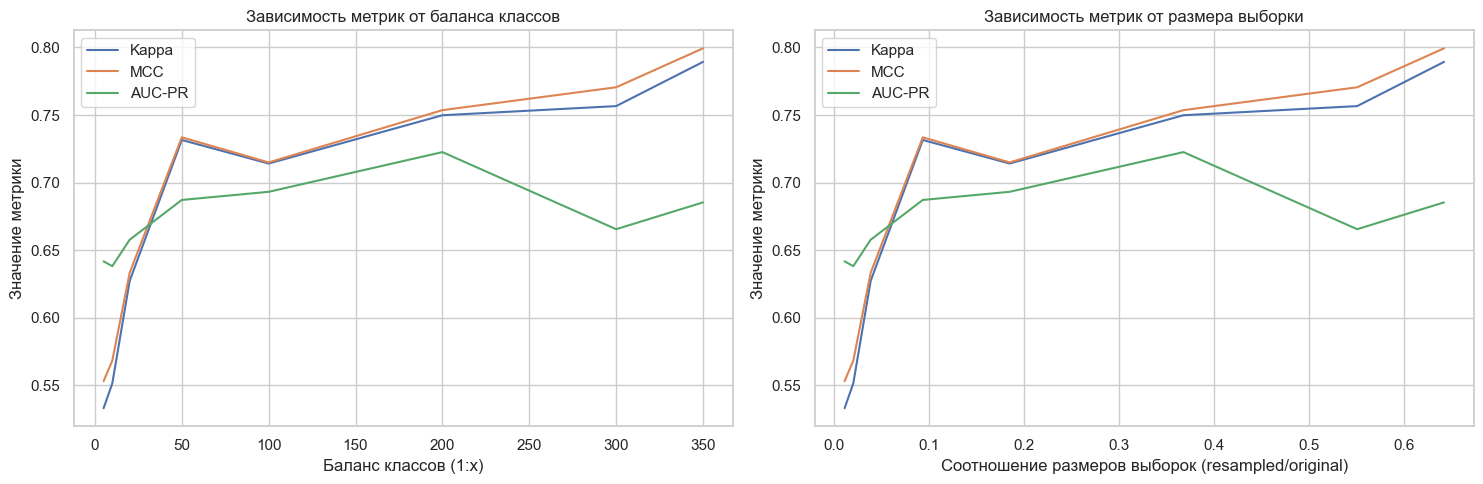

In [229]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(balance_ratios, [kappa_results[r] for r in balance_ratios], label='Kappa')
plt.plot(balance_ratios, [mcc_results[r] for r in balance_ratios], label='MCC')
plt.plot(balance_ratios, [auc_pr_results[r] for r in balance_ratios], label='AUC-PR')
plt.xlabel('Баланс классов (1:x)')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от баланса классов')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
size_ratios = [sample_size_ratios[r] for r in balance_ratios]
plt.plot(size_ratios, [kappa_results[r] for r in balance_ratios], label='Kappa')
plt.plot(size_ratios, [mcc_results[r] for r in balance_ratios], label='MCC')
plt.plot(size_ratios, [auc_pr_results[r] for r in balance_ratios], label='AUC-PR')
plt.xlabel('Соотношение размеров выборок (resampled/original)')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от размера выборки')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

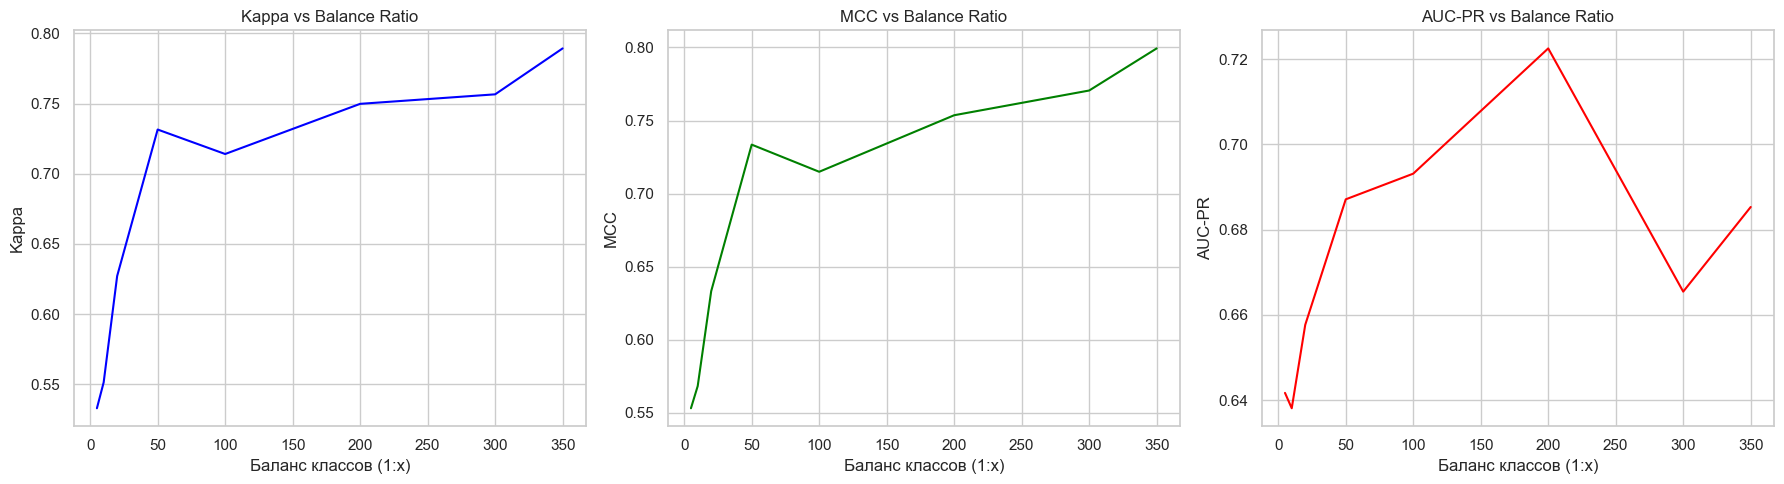

In [231]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(balance_ratios, [kappa_results[r] for r in balance_ratios], color='blue')
axes[0].set_xlabel('Баланс классов (1:x)')
axes[0].set_ylabel('Kappa')
axes[0].set_title('Kappa vs Balance Ratio')
axes[0].grid(True)

axes[1].plot(balance_ratios, [mcc_results[r] for r in balance_ratios], color='green')
axes[1].set_xlabel('Баланс классов (1:x)')
axes[1].set_ylabel('MCC')
axes[1].set_title('MCC vs Balance Ratio')
axes[1].grid(True)

axes[2].plot(balance_ratios, [auc_pr_results[r] for r in balance_ratios], color='red')
axes[2].set_xlabel('Баланс классов (1:x)')
axes[2].set_ylabel('AUC-PR')
axes[2].set_title('AUC-PR vs Balance Ratio')
axes[2].grid(True)

plt.tight_layout()
plt.show()

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [270]:
from imblearn.under_sampling import NearMiss

balance_ratios = [1, 2, 5, 10, 50, 100, 200, 300, 400] 
n_neighbors_list = [3, 7, 9, 13, 15]  
results = {}
for n_neighbors in n_neighbors_list:
    results[n_neighbors] = {}

for n_neighbors in n_neighbors_list:
    for ratio in balance_ratios:
        n_samples_majority = int(np.sum(y_train == 1) * ratio)
        sampling_strategy = {0: n_samples_majority, 1: np.sum(y_train == 1)}
        nm = NearMiss(n_neighbors=n_neighbors, sampling_strategy=sampling_strategy)
        X_train_resampled, y_train_resampled = nm.fit_resample(X_train, y_train)
        resampled_size = len(X_train_resampled)
        size_ratio = resampled_size / original_size
        
        model = CatBoostClassifier(verbose=0, random_seed=42)
        model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val))
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba > best_threshold).astype(int)
            
        kappa = cohen_kappa_manual(y_test, y_pred)
        mcc = matthews_corrcoef_manual(y_test, y_pred)
        auc_pr = average_precision_score(y_test, y_pred_proba)
            
        results[n_neighbors][ratio] = {
                'kappa': kappa,
                'mcc': mcc,
                'auc_pr': auc_pr,
                'size_ratio': size_ratio
        }

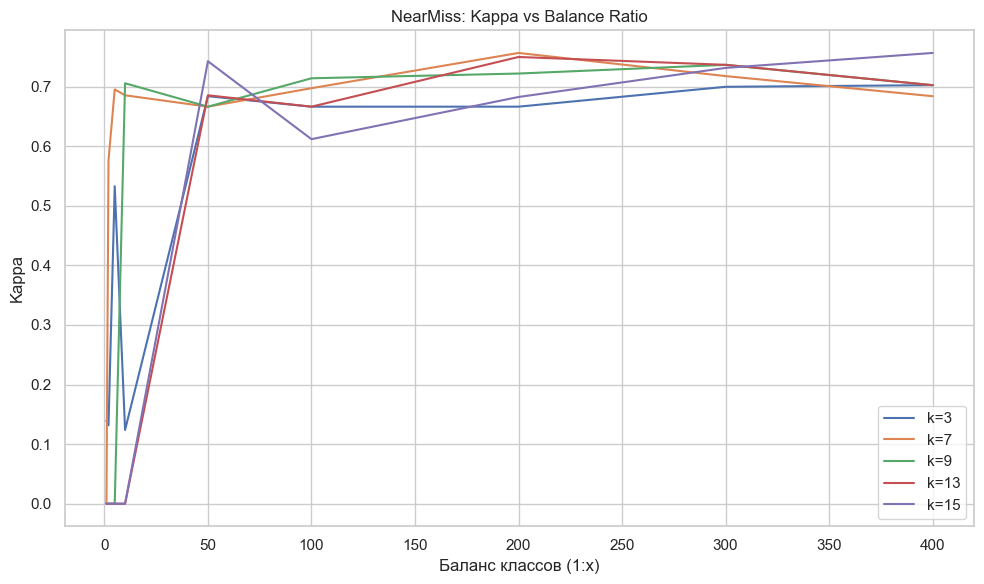

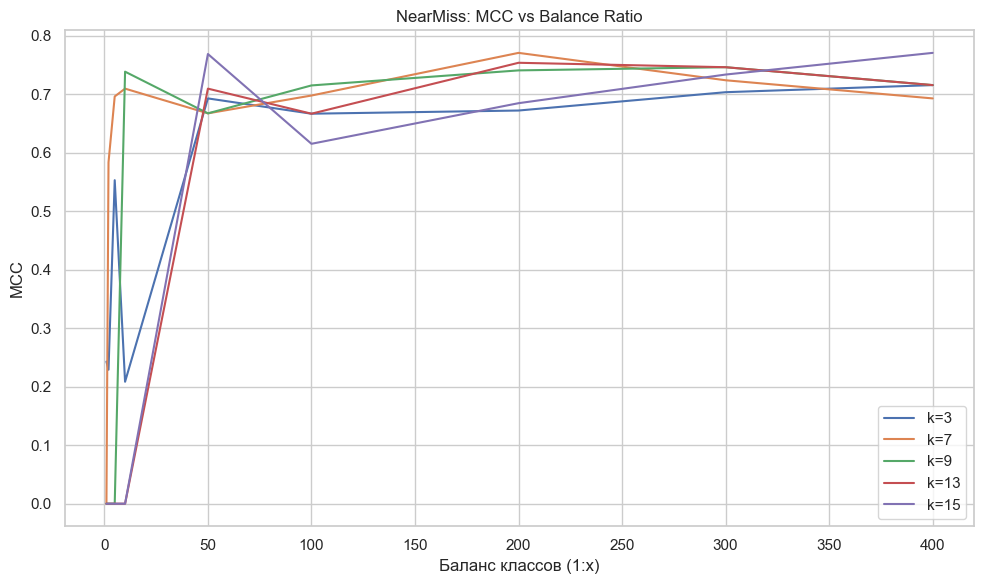

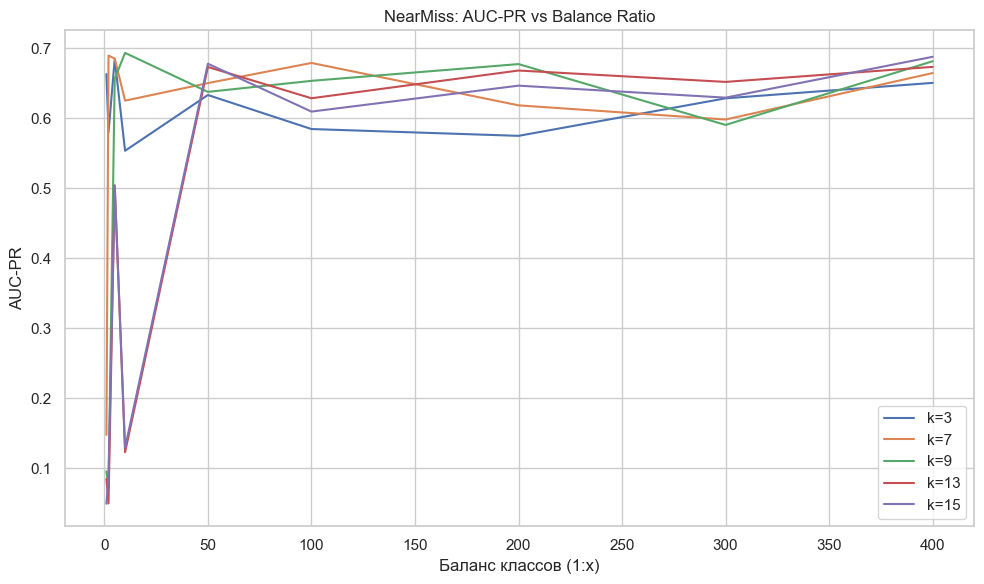

In [271]:
rows = []
for n_neighbors in n_neighbors_list:
    for ratio in balance_ratios:
        if ratio in results[n_neighbors]:
            row = {
                'n_neighbors': n_neighbors,
                'Balance Ratio (1:x)': ratio,
                'Sample Size Ratio': results[n_neighbors][ratio]['size_ratio'],
                'Kappa': results[n_neighbors][ratio]['kappa'],
                'MCC': results[n_neighbors][ratio]['mcc'],
                'AUC-PR': results[n_neighbors][ratio]['auc_pr']
            }
            rows.append(row)

results_df = pd.DataFrame(rows)

plt.figure(figsize=(10, 6))
for n_neighbors in n_neighbors_list:
    ratios = []
    kappas = []
    for ratio in balance_ratios:
        ratios.append(ratio)
        kappas.append(results[n_neighbors][ratio]['kappa'])
    plt.plot(ratios, kappas, label=f'k={n_neighbors}')

plt.xlabel('Баланс классов (1:x)')
plt.ylabel('Kappa')
plt.title(f'NearMiss: Kappa vs Balance Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for n_neighbors in n_neighbors_list:
    ratios = []
    mccs = []
    for ratio in balance_ratios:
        ratios.append(ratio)
        mccs.append(results[n_neighbors][ratio]['mcc'])
    plt.plot(ratios, mccs, label=f'k={n_neighbors}')

plt.xlabel('Баланс классов (1:x)')
plt.ylabel('MCC')
plt.title(f'NearMiss: MCC vs Balance Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for n_neighbors in n_neighbors_list:
    ratios = []
    aucs = []
    for ratio in balance_ratios:
        ratios.append(ratio)
        aucs.append(results[n_neighbors][ratio]['auc_pr'])
    plt.plot(ratios, aucs, label=f'k={n_neighbors}')

plt.xlabel('Баланс классов (1:x)')
plt.ylabel('AUC-PR')
plt.title(f'NearMiss: AUC-PR vs Balance Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

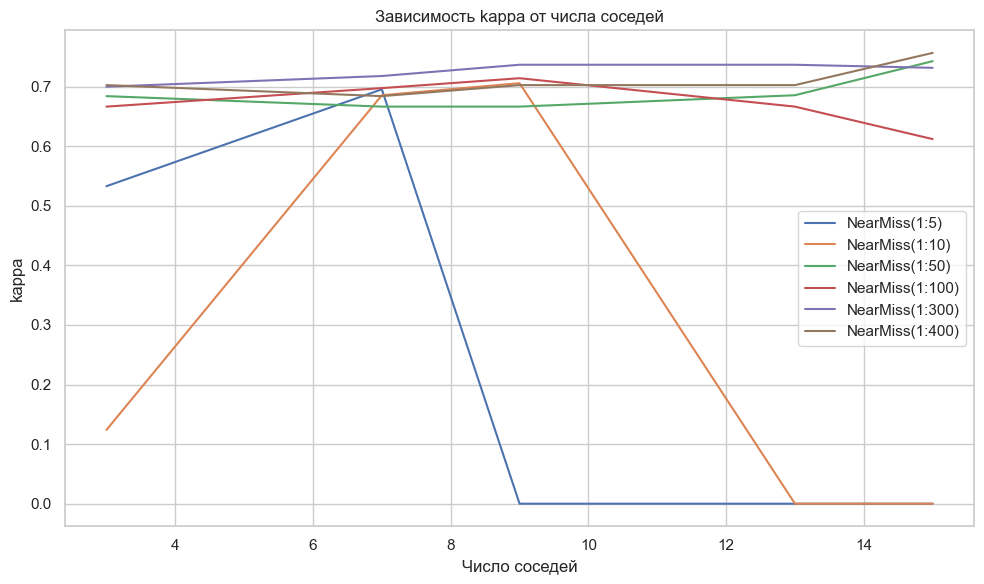

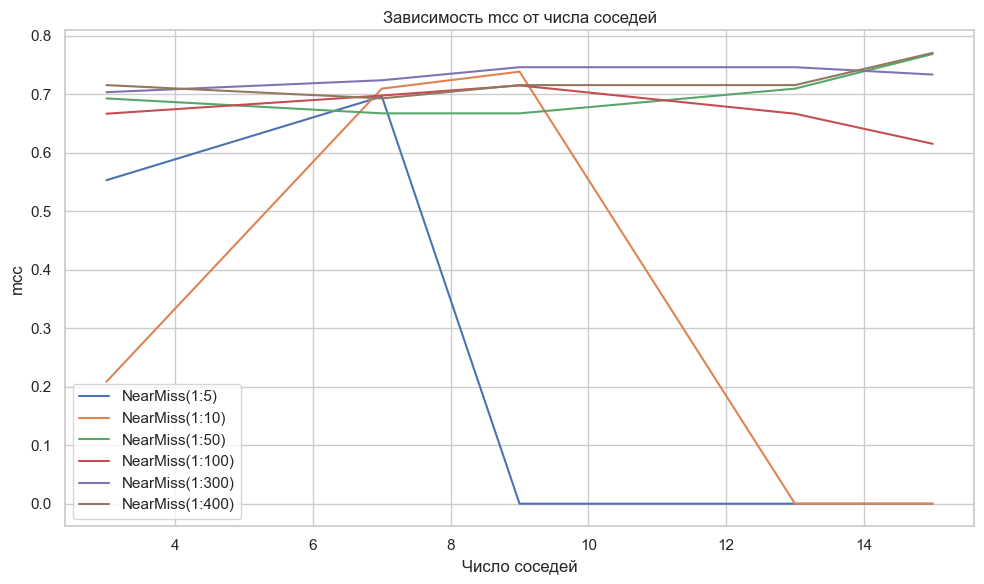

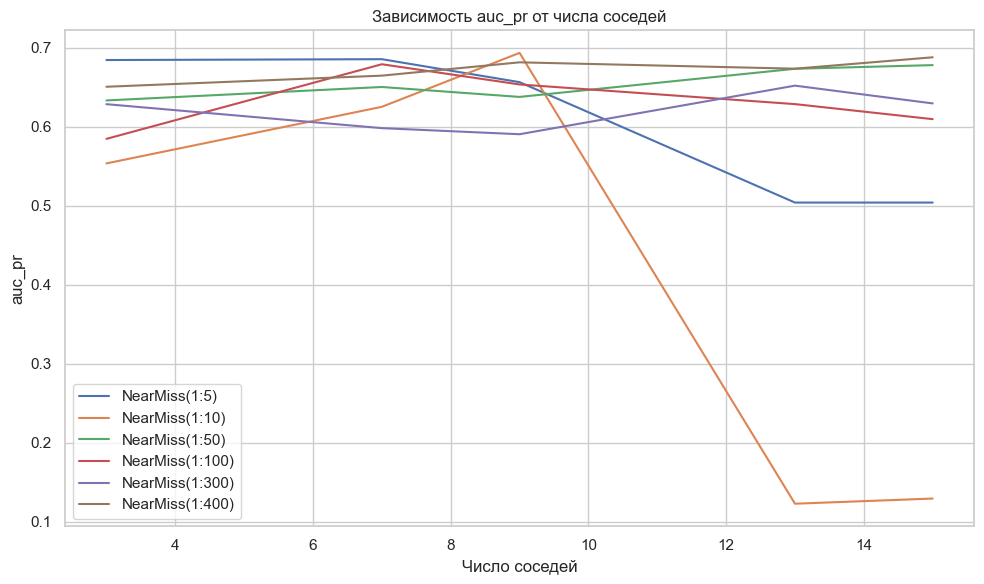

In [272]:
metrics = ['kappa', 'mcc', 'auc_pr']
for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    for ratio in [5, 10, 50, 100, 300, 400]:
        neighbors = []
        values = []
        for n_neighbors in n_neighbors_list:
            neighbors.append(n_neighbors)
            values.append(results[n_neighbors][ratio][metric])
        plt.plot(neighbors, values, label=f'NearMiss(1:{ratio})')
    plt.xlabel('Число соседей')
    plt.ylabel(metric)
    plt.title(f'Зависимость {metric} от числа соседей')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.


EditedNearestNeighbours — это метод андерсэмплинга, который фокусируется на очистке границы между классами. В отличие от NearMiss или случайного андерсэмплинга, которые сокращают примеры мажоритарного класса до заданного количества, ENN удаляет только те экземпляры мажоритарного класса, которые считаются "шумом"
Принцип:
- Для каждого экземпляра в наборе данных находятся k ближайших соседей
- Если класс экземпляра отличается от класса большинства его соседей(mode) (или от всех соседей (all), в зависимости от параметра kind_sel), этот экземпляр удаляется

Преимущество в том, что он сохраняет только примеры мажоритарного класса, которые важны для определения границы решения, и удаляет примеры, которые могут вызывать путаницу в классификации. Получается он потенциально лучше сохраняет распределение

In [286]:
from imblearn.under_sampling import EditedNearestNeighbours

n_neighbors_list = [5, 11, 31, 41, 71, 121, 151, 201, 251, 301, 351, 401] 
kind_sel_list = ['all']  

results = {}
for n_neighbors in n_neighbors_list:
    results[n_neighbors] = {}
    for kind_sel in kind_sel_list:
        results[n_neighbors][kind_sel] = {}

for n_neighbors in n_neighbors_list:
    for kind_sel in kind_sel_list:
        enn = EditedNearestNeighbours(n_neighbors=n_neighbors,kind_sel=kind_sel)
        X_train_resampled, y_train_resampled = enn.fit_resample(X_train, y_train)
        
        resampled_size = len(X_train_resampled)
        size_ratio = resampled_size / original_size
        neg_count = np.sum(y_train_resampled == 0)
        pos_count = np.sum(y_train_resampled == 1)
        class_ratio = neg_count / pos_count if pos_count > 0 else float('inf')
            
        model = CatBoostClassifier(verbose=0, random_seed=42)
        model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val))
            
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba > best_threshold).astype(int)
            
        kappa = cohen_kappa_manual(y_test, y_pred)
        mcc = matthews_corrcoef_manual(y_test, y_pred)
        auc_pr = average_precision_score(y_test, y_pred_proba)

        results[n_neighbors][kind_sel] = {
                'kappa': kappa,
                'mcc': mcc,
                'auc_pr': auc_pr,
                'size_ratio': size_ratio,
                'class_ratio': class_ratio
        }   
        print(f"Results: kappa={kappa:.4f}, mcc={mcc:.4f}, auc_pr={auc_pr:.4f}")

Results: kappa=0.6840, mcc=0.6927, auc_pr=0.6926
Results: kappa=0.6665, mcc=0.6836, auc_pr=0.6682
Results: kappa=0.6665, mcc=0.6836, auc_pr=0.7048
Results: kappa=0.7367, mcc=0.7460, auc_pr=0.6770
Results: kappa=0.6665, mcc=0.6836, auc_pr=0.7144
Results: kappa=0.7367, mcc=0.7460, auc_pr=0.7041
Results: kappa=0.7367, mcc=0.7460, auc_pr=0.6731
Results: kappa=0.7367, mcc=0.7460, auc_pr=0.7160
Results: kappa=0.7893, mcc=0.7994, auc_pr=0.6690
Results: kappa=0.7367, mcc=0.7460, auc_pr=0.7221
Results: kappa=0.7893, mcc=0.7994, auc_pr=0.6595
Results: kappa=0.7566, mcc=0.7705, auc_pr=0.7095


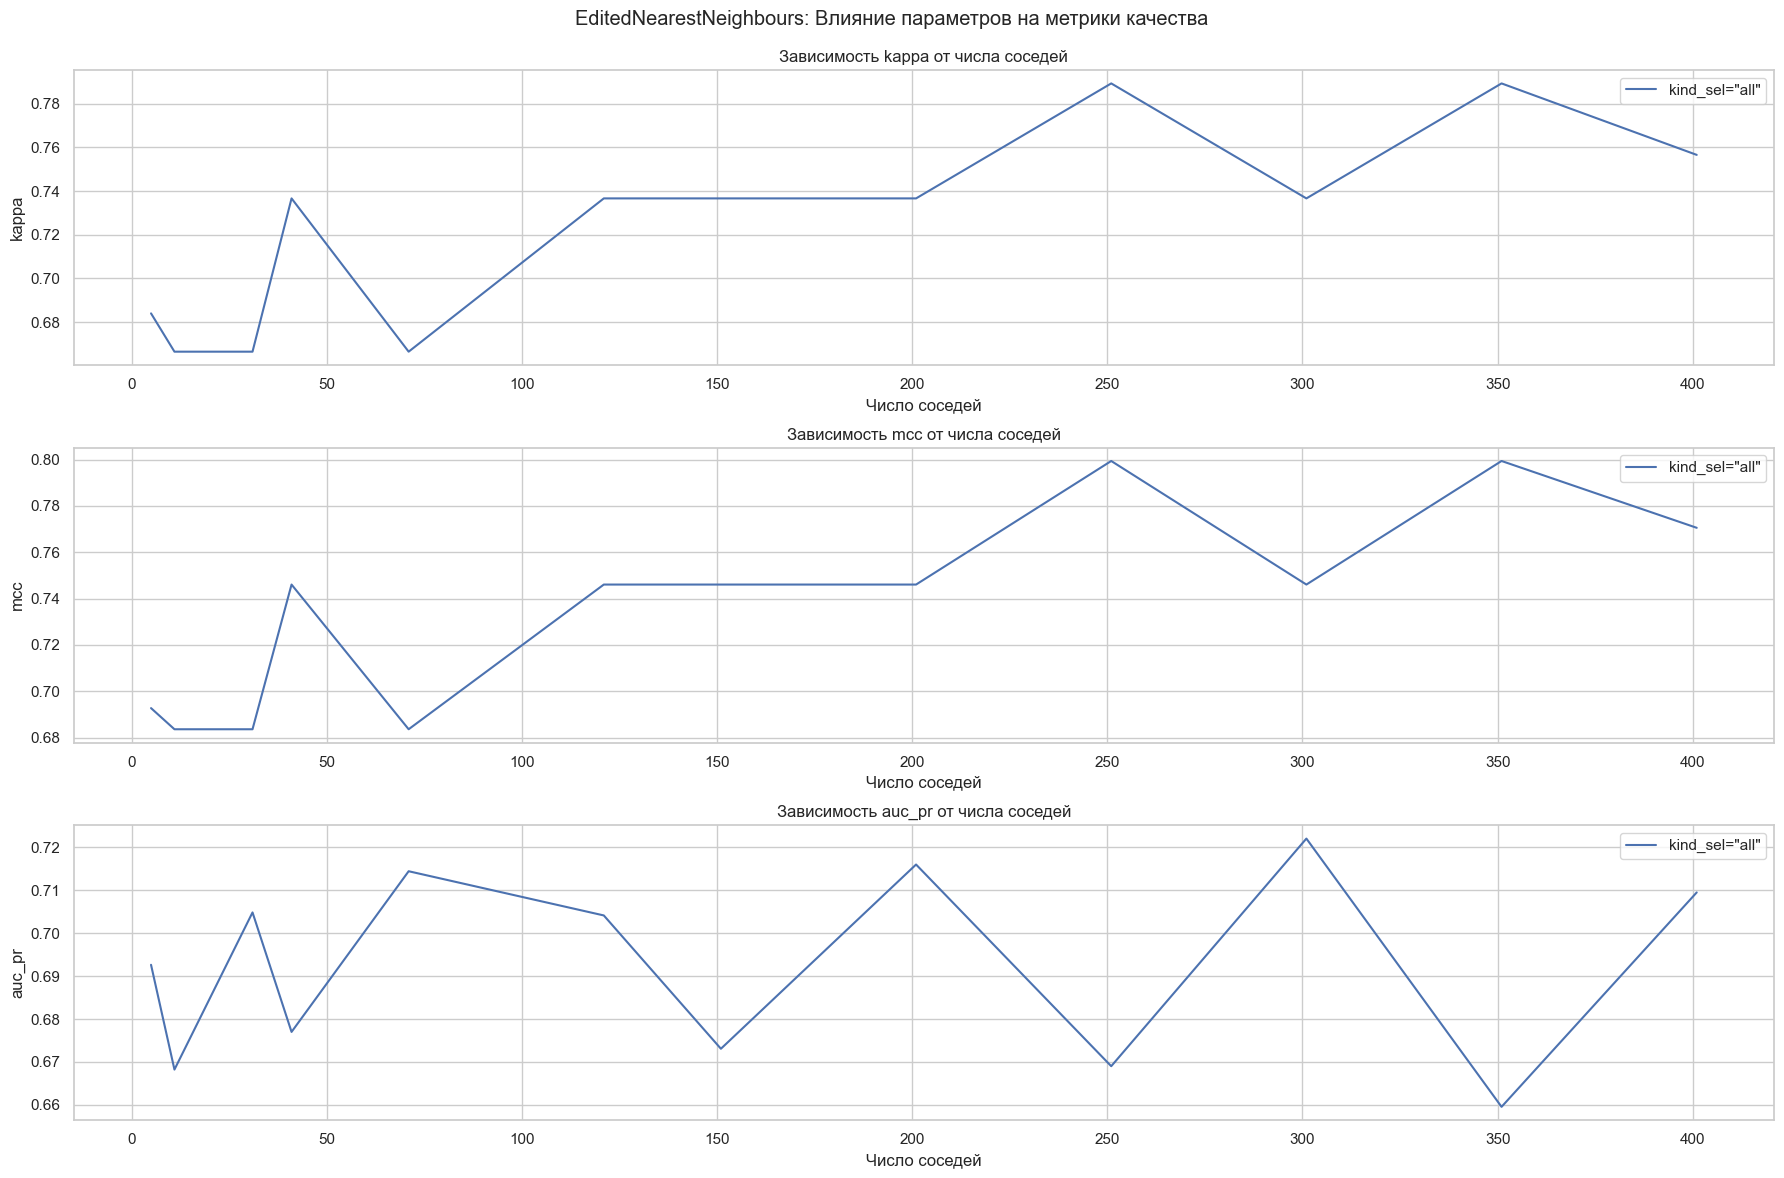

In [287]:
rows = []
for n_neighbors in n_neighbors_list:
    for kind_sel in kind_sel_list:
        if results[n_neighbors][kind_sel]:
            row = {
                'n_neighbors': n_neighbors,
                'kind_sel': kind_sel,
                'Sample Size Ratio': results[n_neighbors][kind_sel]['size_ratio'],
                'Class Ratio (neg:pos)': results[n_neighbors][kind_sel]['class_ratio'],
                'Kappa': results[n_neighbors][kind_sel]['kappa'],
                'MCC': results[n_neighbors][kind_sel]['mcc'],
                'AUC-PR': results[n_neighbors][kind_sel]['auc_pr']
            }
            rows.append(row)

results_df = pd.DataFrame(rows)

plt.figure(figsize=(18, 12))
metrics = ['kappa', 'mcc', 'auc_pr']
for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i+1)
    for kind_sel in kind_sel_list:
        neighbors = []
        values = []
        for n_neighbors in n_neighbors_list:
            neighbors.append(n_neighbors)
            values.append(results[n_neighbors][kind_sel][metric])
        plt.plot(neighbors, values, label=f'kind_sel="{kind_sel}"')
    plt.xlabel('Число соседей')
    plt.ylabel(metric)
    plt.title(f'Зависимость {metric} от числа соседей')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle('EditedNearestNeighbours: Влияние параметров на метрики качества')
plt.subplots_adjust(top=0.93)
plt.show()

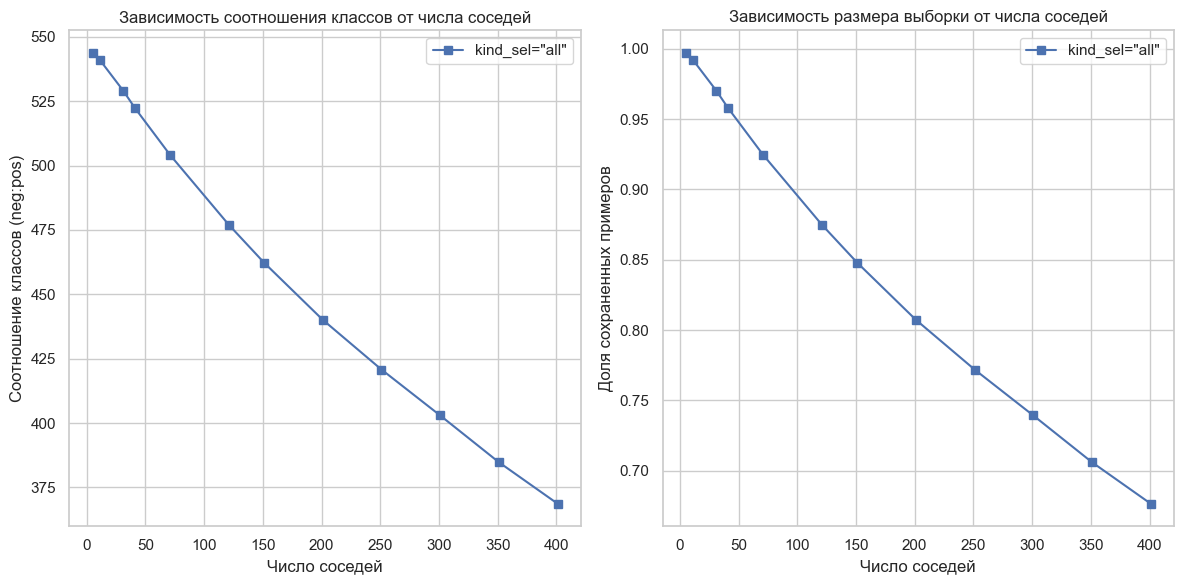

In [290]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for kind_sel in kind_sel_list:
    neighbors = []
    ratios = []
    for n_neighbors in n_neighbors_list:
        neighbors.append(n_neighbors)
        ratios.append(results[n_neighbors][kind_sel]['class_ratio'])
    
    plt.plot(neighbors, ratios, 's-', label=f'kind_sel="{kind_sel}"')

plt.xlabel('Число соседей')
plt.ylabel('Соотношение классов (neg:pos)')
plt.title('Зависимость соотношения классов от числа соседей')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
for kind_sel in kind_sel_list:
    neighbors = []
    ratios = []
    for n_neighbors in n_neighbors_list:
        neighbors.append(n_neighbors)
        ratios.append(results[n_neighbors][kind_sel]['size_ratio'])
    
    plt.plot(neighbors, ratios, 's-', label=f'kind_sel="{kind_sel}"')

plt.xlabel('Число соседей')
plt.ylabel('Доля сохраненных примеров')
plt.title('Зависимость размера выборки от числа соседей')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Так же здесь протестировала kind_sel='mode', но у него результаты в среднем хуже, поэтому оставила только 'all'. В целом, здесь получилось оформить неплохие значения, но явно не лучшие - лучшая версия это ADASYN

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.
- При желании, можете вынести этот код в отдельный файл и приложить его к ноутбуку. Он довольно громоздкий и в ноутбуке такое плохо читается.


**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [291]:
from math import log, ceil

def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    if n <= 1:
        return 0
    return 2 * (np.log(n - 1) + 0.5772156649) - 2 * (n - 1) / n

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    if node.kind == "external":
        return depth + c_factor(node.size)
    
    projections = np.dot(X - node.b, node.w)
    left_indices = projections <= 0
    right_indices = ~left_indices
    if np.any(left_indices):
        scores[left_indices] = calc_height(X[left_indices], depth + 1, node.left)
    
    if np.any(right_indices):
        scores[right_indices] = calc_height(X[right_indices], depth + 1, node.right)
    
    return scores

class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        self.depth = max(self.depth, depth)

        if depth >= self.max_depth or X.shape[0] <= 1:
            self.external_count += 1
            return Node(X, depth, None, None, "external", None, None)
        
        self.internal_count += 1
        w = np.random.randn(X.shape[1])

        if len(X) > 0:
            min_vals = np.min(X, axis=0)
            max_vals = np.max(X, axis=0)
            b = min_vals + np.random.random(X.shape[1]) * (max_vals - min_vals)
        else:
            b = np.zeros(X.shape[1])
  
        projections = np.dot(X - b, w)
        X_left = X[projections <= 0]
        X_right = X[projections > 0]
        left = self.grow(X_left, depth + 1)
        right = self.grow(X_right, depth + 1)
            
        return Node(X, depth, left, right, "internal", w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        #your code here

        return calc_height(X, 0, self.root)
        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        subsample_size = int(self.subsample_rate * X.shape[0])
        
        if self.max_depth is None:
            self.max_depth = ceil(log(subsample_size, 2))
        
        for _ in range(self.n_trees):
            if subsample_size < X.shape[0]:
                indices = np.random.choice(X.shape[0], subsample_size, replace=False)
                X_sampled = X[indices]
            else:
                X_sampled = X
            tree = RandomizedTree(X_sampled, self.max_depth)
            self.trees.append(tree)
        self.is_fit = True
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        tree_scores = np.array([tree.score_samples(X) for tree in self.trees])
        avg_path_lengths = np.mean(tree_scores, axis=0)
        norm_factor = c_factor(self.subsample_rate * X.shape[0])
        scores = 2 ** (-avg_path_lengths / norm_factor)
        
        return scores
    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.score_samples(X)
        
        threshold = np.percentile(scores, 100 * (1 - self.contamination))
        
        labels = np.zeros(X.shape[0], dtype=int)
        labels[scores >= threshold] = 1
        return labels

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [292]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [293]:
def evaluate_model(model, X, y_true):
    scores = model.score_samples(X)
    roc_auc = roc_auc_score(y_true, scores)
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)
    return roc_auc, pr_auc

In [296]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#отберем признаки - иначе результаты не выше 0.22
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

selector = SelectFromModel(rf, threshold="median") 
X_train_rf = selector.fit_transform(X_train_scaled, y_train)
X_test_rf = selector.transform(X_test_scaled)

print(f"Число признаков: {X_train_rf.shape[1]}, оригинальное число признаков: {X_train_scaled.shape[1]}")

Число признаков: 16, оригинальное число признаков: 32


In [297]:
param_grid = {
    'n_trees': [25, 50, 100],
    'subsample_rate': [0.1, 0.2, 0.5],
    'max_depth': [None, 5, 10, 15],
    'contamination': [0.01, 0.05, 0.1]
}

best_pr_auc = 0
best_params = {}
for n_trees in param_grid['n_trees']:
    for subsample_rate in param_grid['subsample_rate']:
        for max_depth in param_grid['max_depth']:
            for contamination in param_grid['contamination']:
                print(f"Processing n_trees: {n_trees}, subsample_rate: {subsample_rate}, max_depth: {max_depth}, contamination: {contamination}")
                eif = ExtendedIsolationForest(
                    n_trees=n_trees,
                    subsample_rate=subsample_rate,
                    max_depth=max_depth,
                    contamination=contamination
                )
                eif.fit(X_train_rf)
                roc_auc, pr_auc = evaluate_model(eif, X_train_rf, y_train)
                if pr_auc > best_pr_auc:
                    best_pr_auc = pr_auc
                    best_params = {
                        'n_trees': n_trees,
                        'subsample_rate': subsample_rate,
                        'max_depth': max_depth,
                        'contamination': contamination
                    }
                    print(f"Новые лучшие параметры: {best_params}, PR AUC: {best_pr_auc:.4f}")

print(f"Лучшие параметры: {best_params}")
best_eif = ExtendedIsolationForest(**best_params)

Processing n_trees: 25, subsample_rate: 0.1, max_depth: None, contamination: 0.01
Новые лучшие параметры: {'n_trees': 25, 'subsample_rate': 0.1, 'max_depth': None, 'contamination': 0.01}, PR AUC: 0.3257
Processing n_trees: 25, subsample_rate: 0.1, max_depth: None, contamination: 0.05
Processing n_trees: 25, subsample_rate: 0.1, max_depth: None, contamination: 0.1
Processing n_trees: 25, subsample_rate: 0.1, max_depth: 5, contamination: 0.01
Processing n_trees: 25, subsample_rate: 0.1, max_depth: 5, contamination: 0.05
Новые лучшие параметры: {'n_trees': 25, 'subsample_rate': 0.1, 'max_depth': 5, 'contamination': 0.05}, PR AUC: 0.3339
Processing n_trees: 25, subsample_rate: 0.1, max_depth: 5, contamination: 0.1
Processing n_trees: 25, subsample_rate: 0.1, max_depth: 10, contamination: 0.01
Processing n_trees: 25, subsample_rate: 0.1, max_depth: 10, contamination: 0.05
Processing n_trees: 25, subsample_rate: 0.1, max_depth: 10, contamination: 0.1
Processing n_trees: 25, subsample_rate: 0

In [303]:
print(f"Лучшие параметры: {best_params}")
best_eif = ExtendedIsolationForest(**best_params)
best_eif.fit(X_train_scaled)
_, eif_pr_auc = evaluate_model(best_eif, X_test_scaled, y_test)

if_params = {
    'n_estimators': best_params['n_trees'],
    'max_samples': int(best_params['subsample_rate'] * X_train_scaled.shape[0]),
    'contamination': best_params['contamination'],
    'random_state': 42
}

standard_if = IsolationForest(**if_params)
standard_if.fit(X_train_scaled)
if_scores = -standard_if.score_samples(X_test_scaled) 
precision, recall, _ = precision_recall_curve(y_test, if_scores)
if_pr_auc = auc(recall, precision)

print(f"Extended Isolation Forest - PR AUC (on scaled): {eif_pr_auc:.4f}")
print(f"Standard Isolation Forest - PR AUC (on scaled): {if_pr_auc:.4f}")

Лучшие параметры: {'n_trees': 50, 'subsample_rate': 0.2, 'max_depth': 5, 'contamination': 0.1}
Extended Isolation Forest - PR AUC (on scaled): 0.0175
Standard Isolation Forest - PR AUC (on scaled): 0.0190


In [358]:
best_eif = ExtendedIsolationForest(**best_params)
best_eif.fit(X_train_rf)
_, eif_pr_auc = evaluate_model(best_eif, X_test_rf, y_test)

standard_if = IsolationForest(**if_params)
standard_if.fit(X_train_rf)
if_scores = -standard_if.score_samples(X_test_rf) 
precision, recall, _ = precision_recall_curve(y_test, if_scores)
if_pr_auc = auc(recall, precision)
print(f"Extended Isolation Forest - PR AUC (on rf - отобранные признаки): {eif_pr_auc:.4f}")
print(f"Standard Isolation Forest - PR AUC (on rf - отобранные признаки): {if_pr_auc:.4f}")

Extended Isolation Forest - PR AUC (on rf - отобранные признаки): 0.0891
Standard Isolation Forest - PR AUC (on rf - отобранные признаки): 0.1121


Как можно заметить, моя реализация eif немного хуже библиотечного if, но с отобранными признаками оба метода получают результаты получше

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [ ]:
#your code here

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [ ]:
#your code here

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [ ]:
#your code here

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [92]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

-0.2535286841332507